# Detection of Spatial Signatures in Barcelona

This notebook contains complete code required for a detection of spatial signatures in Barcelona, limited by its administrative boundary.

This notebook relies on the `gds_env` as its main computational engine, which is deployed on a variety of servers and setups. This means that all the code produced in the project is reproducible under the containers provided in `gds_env`. This notebook uses `gds_py` flavour in a version `6.0`.

For more information on how to run `gds_env`, please visit:

> https://darribas.org/gds_env/

## Contents

- 1. Analysis of form
    - 1.1. Data retrieval
        - 1.1.1. Bulding footprints
        - 1.1.2. Street network
        - 1.1.3. Spatial barriers
    - 1.2. Data pre-processing
        - 1.2.1. Footprints checks and cleaning
        - 1.2.2. Barries checks and cleaning
    - 1.3. Generation of geographies
        - 1.3.1. Enclosures
        - 1.3.2. Enlclosed tessellation
    - 1.4. Morphometric analysis
        - 1.4.1. Primary morphometric characters
        - 1.4.2. Contextualisation
- 2. Analysis of function
    - 2.1. Number of dwellings, Building use, Age
    - 2.2. Land Use
    - 2.3. Block-level data
    - 2.4. Heritage
    - 2.5. Restaurants
    - 2.6. Economic census POIs
    - 2.7. Culture
    - 2.8. Parks
    - 2.9. Trees
    - 2.10. NDVI
- 3. Cluster analysis
    - 3.1. Form
    - 3.2. Function
    - 3.3. Spatial Signatures
- 4. Figures

All packages and custom modules are imported below.

In [7]:
import pickle
import warnings

import dask_geopandas
import geopandas as gpd
import libpysal
import momepy
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
import rasterstats
import requests
import tobler
import utils.momepy
import utils.tobler

from clustergram import Clustergram
from dask.distributed import Client, LocalCluster
from download import download
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
from utils.dask_geopandas import dask_dissolve

import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily

First we specify a path to a folder for a data storage.

In [2]:
folder = "../../urbangrammar_samba/sp_sig_concept/barcelona/"

Most of our data will be stored as geospatial parquet files, which is currently (Feb 2021) in its intial implementation, but we know that and can filter warnings.

In [3]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

## 1. Analysis of form

First step towards spatial signtures is an analysis of urban form to capture its patterns.

### 1.1. Data retrieval

All data used in the work are obtained from open access sources.

#### 1.1.1 Building footprints

Building footprints are obtained from Spanish Cadastre (www.catastro.minhap.es) using ATOM API to retrieve the link for Barcelona.

We fetch the XML with linkst to building data for the whole region and find direct link for a file containing Barcelona

In [16]:
response = requests.get('http://www.catastro.minhap.es/INSPIRE/buildings/08/ES.SDGC.bu.atom_08.xml')
links = []

for link in response.text.split('<link rel="enclosure" href="')[1:]:
    links.append(link.split('"')[0].strip())

In [18]:
bcn = [l for l in links if 'BARCELONA' in l]

In [19]:
bcn

['http://www.catastro.minhap.es/INSPIRE/Buildings/08/08900-BARCELONA/A.ES.SDGC.BU.08900.zip']

Once we have the link, we can download an unzip the data.

In [20]:
data = bcn[0]
path = folder + "buildings"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 44.4M/44.4M [00:11<00:00, 3.70MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/buildings


'../../urbangrammar_samba/sp_sig_concept/barcelona/buildings'

#### 1.1.2. Street network

Street network is retrieved from [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/mapa-graf-viari-carrers-wms).

In [14]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/6fd03b36-7503-42f0-9082-9040cb812423/resource/a11a534d-4aeb-497f-b6bd-2e170b4724aa/download"
path = folder + "streets"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.84M/1.84M [00:01<00:00, 1.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/streets


'../../urbangrammar_samba/sp_sig_concept/barcelona/streets'

#### 1.1.3. Spatial barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore, we download railway and water geometry from OSM. We can filter the requred data by the bounding box of roads.

In [23]:
roads = gpd.read_file(folder + "streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")

In [50]:
bounds = roads.to_crs(4326).total_bounds
bounds

array([ 2.05905748, 41.32133238,  2.22232372, 41.46827616])

Using `OSMnx` we can specify OSM tags, selecting which geometries should be downloaded. First we get water-related barriers.

In [ ]:
tags = {'natural': ['water', 'coastline', 'spring']}

water = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
water = water.to_crs(roads.crs)
water[['natural', 'geometry']].to_parquet(folder + "barrriers/water.pq")

Then we get railway and filter out proper geometry type (we want LineStrings representing railway tracks) and remove tunnels and trams (those are not spatial barriers).

In [ ]:
tags = {'railway': True}

railway = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
railway = railway.to_crs(roads.crs)
railway = railway[railway.geom_type == 'LineString']
railway = railway[railway.tunnel != 'yes']
railway = railway[~railway.railway.isin(['miniature', 'tram'])]
railway[['railway', 'geometry']].to_parquet(folder + "barrriers/railway.pq")

External boundary of the case study is limited by administrative boudnary of the city, so we download the data represeting amdinistrative units from Open Data BCN.

In [67]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/808daafa-d9ce-48c0-925a-fa5afdb1ed41/resource/cd800462-f326-429f-a67a-c69b7fc4c50a/download"
path = folder + "admin/admin_units"
download(data, path, kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 2.82M/2.82M [00:02<00:00, 1.15MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units


'../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units'

In [68]:
admin = gpd.read_file(folder + "admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

### 1.2. Data pre-processing

Before we can analyse form using the data we just downloaded, we need to ensure that they are in a proper form.

#### 1.2.1. Footprints checks and cleaning

Let's start with building footprints.

In [ ]:
buildings = gpd.read_file(folder + "buildings/A.ES.SDGC.BU.08900.building.gml")

First, we should ensure that all geometries are single-part.

In [ ]:
buildings = buildings.explode()

We can then use `momepy.CheckTessellationInput()` class to check for potential issues which may arise during enclosed tessellation.

In [95]:
check = momepy.CheckTessellationInput(buildings)

/opt/conda/lib/python3.8/site-packages/momepy/utils.py:1003: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  shrink = shrink[~(shrink.is_empty | shrink.geometry.isna())]


Collapsed features  : 86
Split features      : 339
Overlapping features: 0


We see that 86 buildings would collapse (disappear) and 339 would be split, which may result in multipolygon tessellation cells.

In [98]:
check.collapse.area.max()

22.907883144854168

Since the maximum area of collapsed feature is 23 sq.m. we can safely remove them.

In [99]:
buildings = buildings.drop(check.collapse.index)

We can keep builsing which would be split, we should just be aware that it may happen.

In [100]:
buildings.shape

(81440, 25)

This results in 81 440 cleaned buildings. We will assign unique ID to each of them and save them to a file.

In [101]:
buildings["uID"] = range(len(buildings))

In [ ]:
buildings.to_parquet(folder + "buildings.pq")

#### 1.2.2. Barries checks and cleaning

Let's now check our barriers and close potential unwanted gaps to generate clean enclosures

In [104]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [109]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

Roads seems to be fine, similarly to railway. The only step we do is extension of railway lines to snap to roads.

In [116]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

### 1.3. Generation of geographies

Now we have to create geographies we will be using in the analysis. Enclosures and enclosed tessellation.

#### 1.3.1. Enclosures

Enclosures require spatial barriers, which are roads and railway (we use the extended one we did above), limited by administrative boundary.

In [2]:
roads = gpd.read_file(folder + "streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")
admin = gpd.read_file(folder + "admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

In [4]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=admin.iloc[[0]], additional_barriers=[extended_railway])

CPU times: user 1.4 s, sys: 8.11 ms, total: 1.41 s
Wall time: 1.41 s


#### 1.3.2. Enclosed tessellation

With enclosures and buildings, we can now create enclosed tessellation.

In [ ]:
buildings = gpd.read_parquet(folder + "buildings.pq")

In [7]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 48min 53s, sys: 4min 6s, total: 53min
Wall time: 19min 19s


Finally, we can save both newly generated geographies to files.

In [ ]:
tess.tessellation.to_parquet(folder + "tessellation.pq")

In [ ]:
enclosures.to_parquet(folder + "enclosures.pq")

### 1.4. Morphometric analysis

Morpohmetric analysis first measures primary characters, which are then contextualised to capture the tendencies within the local context of each tessellation cell.

#### 1.4.1. Primary morphometric characters

For the analysis we need four input layer representing urban form - buildings, streets, enclosed tessellation and enclosures.

In [2]:
blg = gpd.read_parquet(folder + "buildings.pq")
streets = gpd.read_file(folder + "streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")
tess = gpd.read_parquet(folder + "tessellation.pq")
enclosures = gpd.read_parquet(folder + "enclosures.pq")

In many cases, we will need to relate buildings to tessellation cells. the best way to ensure the proper linkage is to combine both GeoDataFrames into a single one with two named geometry columns. Then we can assign unique ID to each tessellation cell. Remember that not every cell has assigned a building.

In [3]:
tess = tess.rename_geometry("tessellation").merge(
    blg[["uID", "geometry"]].rename_geometry("buildings"), on="uID", how="left"
)

In [4]:
tess['tID'] = range(len(tess))

In [5]:
tess

uID                                       tessellation   eID  \
0      32004.0  POLYGON ((432134.537 4581026.154, 432114.514 4...     0   
1      32005.0  POLYGON ((432143.300 4581011.416, 432142.423 4...     0   
2      32006.0  POLYGON ((432119.125 4581004.320, 432141.346 4...     0   
3      32007.0  POLYGON ((432148.249 4581003.971, 432148.271 4...     0   
4      32008.0  POLYGON ((432148.624 4580987.010, 432147.673 4...     0   
...        ...                                                ...   ...   
82370  56448.0  POLYGON ((427288.332 4577151.951, 427302.223 4...  5852   
82371      NaN  POLYGON ((427407.654 4577101.819, 427405.996 4...  5853   
82372      NaN  POLYGON ((427194.177 4576961.126, 427213.001 4...  5854   
82373      NaN  POLYGON ((427480.333 4577076.215, 427501.055 4...  5855   
82374      NaN  POLYGON ((426836.909 4583807.381, 426836.623 4...  5857   

                                               buildings    tID  
0      POLYGON ((432150.502 4581030.798, 432148.781 4...      0  
1      POLYGON ((432141.079 4581028.136, 432143.721 4...      1  
2      POLYGON ((432148.111 4581012.778, 432148.341 4...      2  
3      POLYGON ((432159.642 4581004.302, 432160.339 4...      3  
4      POLYGON ((432155.041 4580997.493, 432155.961 4...      4  
...                                                  ...    ...  
82370  POLYGON ((427233.783 4576977.073, 427229.417 4...  82370  
82371                                               None  82371  
82372                                               None  82372  
82373                                               None  82373  
82374                                               None  82374  

[82375 rows x 5 columns]

From the combined GeoDataFrame, we can create one with buildings as an active geometry, dropping rows which do not have any buildings.

In [6]:
blg = tess.set_geometry('buildings').dropna()

Now, we can measure morphometric characters. Refer to the [documentation of momepy](https://docs.momepy.org) for details on each one of them. Each result is assigned as a new column.

In [7]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series

CPU times: user 16.2 ms, sys: 106 µs, total: 16.3 ms
Wall time: 15.1 ms
CPU times: user 17.4 ms, sys: 704 µs, total: 18.1 ms
Wall time: 17.6 ms
CPU times: user 113 ms, sys: 22.7 ms, total: 135 ms
Wall time: 132 ms


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:773: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  1%|          | 436/81567 [00:00<00:18, 4358.95it/s]

CPU times: user 4.73 s, sys: 33.5 ms, total: 4.76 s
Wall time: 4.74 s


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:862: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
  0%|          | 248/81567 [00:00<00:32, 2478.35it/s]

CPU times: user 25.4 s, sys: 189 ms, total: 25.5 s
Wall time: 25.4 s


 95%|█████████▌| 77673/81567 [00:43<00:02, 1701.29it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 81567/81567 [00:47<00:00, 1710.51it/s]


CPU times: user 47.6 s, sys: 593 ms, total: 48.2 s
Wall time: 47.7 s
CPU times: user 32.9 s, sys: 39.1 ms, total: 33 s
Wall time: 33 s
CPU times: user 32.9 s, sys: 7.67 ms, total: 32.9 s
Wall time: 32.9 s


In [8]:
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1080: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 283/81567 [00:00<00:28, 2821.77it/s]

CPU times: user 46.1 s, sys: 116 ms, total: 46.3 s
Wall time: 46.1 s


  0%|          | 195/82375 [00:00<00:42, 1943.83it/s]

CPU times: user 35.7 s, sys: 72.3 ms, total: 35.8 s
Wall time: 35.7 s


100%|██████████| 82375/82375 [01:42<00:00, 800.64it/s] 

CPU times: user 1min 43s, sys: 132 ms, total: 1min 43s
Wall time: 1min 42s


For the next one, we will need building orientation in a full dataframe with tessellation, so we merge it back.

In [9]:
tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

In [10]:
%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 1.37 ms


In [11]:
%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']

CPU times: user 13.8 s, sys: 11.9 ms, total: 13.8 s
Wall time: 13.8 s
CPU times: user 95.1 ms, sys: 0 ns, total: 95.1 ms
Wall time: 94.7 ms
CPU times: user 14.1 s, sys: 19.9 ms, total: 14.1 s
Wall time: 14.1 s
CPU times: user 1min 39s, sys: 143 ms, total: 1min 39s
Wall time: 1min 39s
CPU times: user 16.6 ms, sys: 5 µs, total: 16.6 ms
Wall time: 15.4 ms


In [12]:
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 32.8 s, sys: 0 ns, total: 32.8 s
Wall time: 32.8 s


Some of the characters require spatial weights matrices. We can generate Queen contiguity based on enclosed tessellation.

In [13]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')

CPU times: user 1min 2s, sys: 1.26 s, total: 1min 4s
Wall time: 1min 4s


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [14]:
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series

100%|██████████| 82375/82375 [00:34<00:00, 2390.71it/s]

CPU times: user 34.9 s, sys: 1.71 s, total: 36.6 s
Wall time: 34.5 s


In [15]:
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series

100%|██████████| 82375/82375 [00:40<00:00, 2040.14it/s]

CPU times: user 40.4 s, sys: 120 ms, total: 40.5 s
Wall time: 40.4 s


In [16]:
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series

  0%|          | 0/82375 [00:00<?, ?it/s]

CPU times: user 853 ms, sys: 37 µs, total: 853 ms
Wall time: 849 ms


100%|██████████| 82375/82375 [00:13<00:00, 5988.93it/s]

CPU times: user 14.1 s, sys: 1.3 s, total: 15.4 s
Wall time: 13.9 s


In some cases, we need to capture contiguity of buidings. Let's generate Queen contiguity based on a building layer,

In [17]:
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series

  0%|          | 0/81567 [00:00<?, ?it/s]

CPU times: user 8.53 s, sys: 132 ms, total: 8.66 s
Wall time: 8.65 s


100%|██████████| 81567/81567 [00:00<00:00, 3032493.28it/s]

CPU times: user 49.6 s, sys: 5.13 s, total: 54.8 s
Wall time: 46.1 s


In [18]:
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series

100%|██████████| 81567/81567 [00:51<00:00, 1586.14it/s]

CPU times: user 55.2 s, sys: 4.97 s, total: 1min
Wall time: 51.5 s


Characters often require specification of immediate context. In our case, we use the inlcusive third order contiguity, which can be easily generated based on the intial Queen contiguity.

In [19]:
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)

CPU times: user 5.57 s, sys: 180 ms, total: 5.75 s
Wall time: 5.74 s


In [20]:
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

  1%|          | 416/82375 [00:00<00:37, 2157.26it/s]

Computing mean interbuilding distances...


100%|█████████▉| 82124/82375 [00:55<00:00, 570.74it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 82375/82375 [00:55<00:00, 1475.96it/s]


CPU times: user 1min 5s, sys: 563 ms, total: 1min 6s
Wall time: 1min 5s


We also need to link tessellation cells to streets. We do it based on intersection. The following gives us the ratio if the tessellation intersects more than one cell.

In [21]:
%time links = momepy.get_network_ratio(tess, streets)

CPU times: user 1min 17s, sys: 8.43 ms, total: 1min 17s
Wall time: 1min 17s


In [22]:
tess[['edgeID_keys', 'edgeID_values']] = links

From these ratios we can get the primary link (the one which intersects the most).

In [23]:
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]

Since we need these links on both tessellation and buildings, we merge the result to `blg`.

In [24]:
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')

We also need to make sure that intially intereger index used as edgeID is preserved as an attribtue of streets in case we shuffle the data.

In [25]:
streets['edgeID_primary'] = range(len(streets))

Now we can measure the characters combining multiple data sources.

In [26]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 1.86 ms, sys: 39 µs, total: 1.9 ms
Wall time: 999 µs
CPU times: user 402 ms, sys: 14 µs, total: 402 ms
Wall time: 401 ms
CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 410 ms


In [27]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 2min 53s, sys: 55.7 ms, total: 2min 53s
Wall time: 2min 53s


In [28]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 258 ms, sys: 3.9 ms, total: 262 ms
Wall time: 261 ms


In [29]:
%%time 
# Area Covered by each edge

vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 1.38 s, sys: 3.99 ms, total: 1.38 s
Wall time: 1.38 s


In [30]:
%%time
# Buildings per meter

bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

CPU times: user 4.34 s, sys: 15.8 ms, total: 4.35 s
Wall time: 4.34 s


Street network forms a graph. We can use this property to first define a context of each segment.

In [31]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(
    streets, silence_warnings=True
)

streets["misRea"] = momepy.Reached(
    streets,
    tess,
    "edgeID_primary",
    "edgeID_primary",
    spatial_weights=str_q1,
    mode="count",
).series

streets["mdsAre"] = momepy.Reached(
    streets,
    tess,
    "edgeID_primary",
    "edgeID_primary",
    spatial_weights=str_q1,
    mode="sum",
).series

100%|██████████| 14831/14831 [00:25<00:00, 588.91it/s]


And then to create graph representation and measure connectivity characters. The cell below creates `networkX.MultiGraph`, measures characters and returns two GeoDataFrames - original segments and nodes, accompanied with spatial weights.

In [32]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.68 s
node degree


  0%|          | 0/9484 [00:00<?, ?it/s]

subgraph


100%|██████████| 9484/9484 [00:19<00:00, 496.93it/s]


cds length


100%|██████████| 9484/9484 [00:06<00:00, 1490.19it/s]


clustering


  0%|          | 0/9484 [00:00<?, ?it/s]

mean_node_dist


100%|██████████| 9484/9484 [00:00<00:00, 70278.67it/s]


CPU times: user 402 ms, sys: 3 µs, total: 402 ms
Wall time: 401 ms


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  warnings.warn(message)


Weights and connections allow us to measure characters on a "subgraph" even without the networkX object.

In [33]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

 18%|█▊        | 2617/14831 [00:00<00:00, 13149.51it/s]

CPU times: user 1.46 s, sys: 7.82 ms, total: 1.46 s
Wall time: 1.46 s


100%|██████████| 14831/14831 [00:01<00:00, 13172.95it/s]


CPU times: user 1.12 s, sys: 181 ms, total: 1.3 s
Wall time: 1.13 s


  2%|▏         | 153/9484 [00:00<00:06, 1528.01it/s]

CPU times: user 817 ms, sys: 0 ns, total: 817 ms
Wall time: 816 ms


  1%|          | 79/9484 [00:00<00:12, 783.01it/s]

CPU times: user 6.25 s, sys: 11.7 ms, total: 6.26 s
Wall time: 6.24 s


100%|██████████| 9484/9484 [00:12<00:00, 784.32it/s]


Now we also include enclosures in the set.

In [34]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 5860/5860 [00:02<00:00, 2870.77it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 5466, 5467.
  warnings.warn(message)


In [35]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [36]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 82375/82375 [00:53<00:00, 1551.67it/s]


We will need to link data which are now on nodes to tessellation, so we need to get nearest network-based node ID.

In [37]:
# get node id
%time links = momepy.get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = momepy.get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

  0%|          | 293/82375 [00:00<00:28, 2920.18it/s]

CPU times: user 1min 18s, sys: 232 µs, total: 1min 18s
Wall time: 1min 18s


100%|██████████| 82375/82375 [00:28<00:00, 2849.70it/s]

CPU times: user 28.9 s, sys: 87.1 ms, total: 29 s
Wall time: 28.9 s


In [38]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 9484/9484 [00:08<00:00, 1181.84it/s]

CPU times: user 8.06 s, sys: 7.76 ms, total: 8.07 s
Wall time: 8.03 s


Finally, we link all GeoDataFrames together.

In [40]:
tess.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID'],
      dtype='object')

In [41]:
blg.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'mtbSWR', 'ldbPWL', 'libNCo', 'edgeID_primary',
       'stbSAl'],
      dtype='object')

In [42]:
edges.columns

Index(['COORD_X', 'COORD_Y', 'LONGITUD', 'ANGLE', 'C_Tram', 'C_Nus_I',
       'C_Nus_F', 'Distric_D', 'NDistric_D', 'Illa_D', 'CVia_D', 'TVia_D',
       'NVia_D', 'Tram_Dret', 'Distric_E', 'NDistric_E', 'Illa_E', 'CVia_E',
       'TVia_E', 'NVia_E', 'Tram_Esq', 'geometry', 'edgeID_primary', 'sdsLen',
       'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea',
       'mdsAre', 'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL'],
      dtype='object')

In [43]:
nodes.columns

Index(['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0',
       'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'geometry',
       'lddNDe', 'linWID', 'sddAre'],
      dtype='object')

In [44]:
enclosures.columns

Index(['eID', 'geometry', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA',
       'lteOri', 'neighbors', 'lteWNB', 'lieWCe'],
      dtype='object')

In [45]:
data = tess.merge(
    blg[
        [
            "tID",
            "sdbAre",
            "sdbPer",
            "sdbCoA",
            "ssbCCo",
            "ssbCor",
            "ssbSqu",
            "ssbERI",
            "ssbElo",
            "ssbCCM",
            "ssbCCD",
            "mtbSWR",
            "ldbPWL",
            "stbSAl",
            "libNCo",
        ]
    ],
    on="tID",
    how="left",
)
data = data.merge(
    edges[
        [
            "sdsLen",
            "sdsSPW",
            "sdsSPO",
            "sdsSWD",
            "sssLin",
            "sdsAre",
            "sisBpM",
            "misRea",
            "mdsAre",
            "ldsMSL",
            "edgeID_primary",
        ]
    ],
    on="edgeID_primary",
    how="left",
)
data = data.merge(
    nodes[
        [
            "degree",
            "meshedness",
            "proportion_3",
            "proportion_4",
            "proportion_0",
            "local_closeness",
            "ldsCDL",
            "xcnSCl",
            "mtdMDi",
            "nodeID",
            "lddNDe",
            "linWID",
            "sddAre",
        ]
    ],
    on="nodeID",
    how="left",
)
data = data.merge(
    enclosures[
        [
            "eID",
            "ldeAre",
            "ldePer",
            "lseCCo",
            "lseERI",
            "lseCWA",
            "lteOri",
            "lteWNB",
            "lieWCe",
        ]
    ],
    on="eID",
    how="left",
)

In [46]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

Now we save all data to parquet files.

In [ ]:
data.to_parquet(folder + "data.pq")

In [ ]:
tess.to_parquet(folder + "tess.pq")
blg.to_parquet(folder + "blg.pq")
nodes.to_parquet(folder + "nodes.pq")
edges.to_parquet(folder + "edges.pq")
enclosures.to_parquet(folder + "enclosures.pq")

#### 1.4.2. Contextualisation

Cluster analysis needs to be performant on large datasets, therefore it should not contain spatial constraints (such algorithms do not scale well). At the same time, we are interested in the tendency of characters within the area. Most primary characters are local only, with minimal or no sense of context. Therefore, we do the contextualisation of each primary character to get the first, second and third quartile of the distribution of values within inclusive 10th order of contiguity around each tessellation cell, weighted by the inverse distance between cell's centroids.

First we need to load the data (unless they are still in memory from the steps above).

In [3]:
data = gpd.read_parquet(folder + "data.pq")

In [3]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

Now we specify columns representing characters and nothing else (geometry, IDs).

In [4]:
characters = [
    "stcOri",
    "stbOri",
    "stbCeA",
    "sdcLAL",
    "sdcAre",
    "sscCCo",
    "sscERI",
    "sicCAR",
    "mtbAli",
    "mtbNDi",
    "mtcWNe",
    "mdcAre",
    "ltbIBD",
    "stcSAl",
    "ltcWRE",
    "sdbAre",
    "sdbPer",
    "sdbCoA",
    "ssbCCo",
    "ssbCor",
    "ssbSqu",
    "ssbERI",
    "ssbElo",
    "ssbCCM",
    "ssbCCD",
    "mtbSWR",
    "ldbPWL",
    "stbSAl",
    "libNCo",
    "sdsLen",
    "sdsSPW",
    "sdsSPO",
    "sdsSWD",
    "sssLin",
    "sdsAre",
    "sisBpM",
    "misRea",
    "mdsAre",
    "ldsMSL",
    "degree",
    "meshedness",
    "proportion_3",
    "proportion_4",
    "proportion_0",
    "local_closeness",
    "ldsCDL",
    "xcnSCl",
    "mtdMDi",
    "lddNDe",
    "linWID",
    "sddAre",
    "ldeAre",
    "ldePer",
    "lseCCo",
    "lseERI",
    "lseCWA",
    "lteOri",
    "lteWNB",
    "lieWCe",
]

We prepare `gdf`, which contains characters and tessellation centroids as a geometry and `W`, spatial weights matrix rperesenting 10th order of contiguity (inclusive).

In [5]:
gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


CPU times: user 3min 12s, sys: 5.86 s, total: 3min 18s
Wall time: 3min 18s


Then we can loop over the GeoDataFrame and measure contextualisation of each character.

In [6]:
convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = 1 / distance
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        nan_mask = np.isnan(values)
        if nan_mask.all():
            convolutions[c].append(np.array([np.nan] * 3))
        else:
            sample_weight = distance_decay.values[sorter][~nan_mask]
            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            weighted_quantiles /= np.sum(sample_weight)
            interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
            convolutions[c].append(interpolate)

100%|██████████| 82375/82375 [07:53<00:00, 174.11it/s]


Resulting dictionary can be then exploded to a DataFrame with the tessellation ID as an index.

In [7]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 1.02 s, sys: 8.05 ms, total: 1.02 s
Wall time: 1.02 s
CPU times: user 6.48 s, sys: 52 ms, total: 6.53 s
Wall time: 6.53 s


In [8]:
exploded.index = data.tID
exploded

stcOri_q1  stcOri_q2  stcOri_q3  stbOri_q1  stbOri_q2  stbOri_q3  \
tID                                                                       
0      15.913145  16.159552  18.765073  15.892685  16.119547  17.820925   
1      15.907666  16.151942  16.760080  15.870827  16.113252  16.720064   
2      15.896767  16.141307  16.636830  15.862692  16.089979  16.613978   
3      15.927605  16.141307  16.484717  15.887919  16.107625  16.499216   
4      15.927605  16.141307  16.465360  15.882925  16.102243  16.499709   
...          ...        ...        ...        ...        ...        ...   
82370  19.829797  25.271437  26.793978  23.398681  25.319963  26.901155   
82371  19.760997  25.272491  27.155652  23.409577  25.330626  27.520789   
82372  20.157519  25.287139  26.638629  23.517962  25.330938  26.243829   
82373  20.641778  25.307169  27.216922  23.517450  25.373507  27.188862   
82374  31.005338  35.706428  36.949608  33.143719  35.691569  36.360094   

       stbCeA_q1  stbCeA_q2  stbCeA_q3  sdcLAL_q1  ...    lseCWA_q3  \
tID                                                ...                
0       0.100600   0.267895   0.627592  17.064057  ...    92.635877   
1       0.094737   0.245316   0.596729  17.197370  ...    92.772535   
2       0.084145   0.230507   0.556111  17.247088  ...    92.772535   
3       0.078247   0.215081   0.498972  17.343866  ...    92.772535   
4       0.068921   0.205704   0.505266  17.318477  ...    92.772535   
...          ...        ...        ...        ...  ...          ...   
82370   0.339884   2.192982   9.536889  37.573864  ...  4580.498311   
82371   0.343211   2.140282   9.538044  37.935575  ...  4580.498311   
82372   0.308285   1.891952   8.769012  38.349772  ...  4580.498311   
82373   0.357848   2.384726   9.672223  36.492276  ...  4580.498311   
82374   0.530007   2.663057   7.347365  32.260248  ...   102.044042   

       lteOri_q1  lteOri_q2  lteOri_q3  lteWNB_q1  lteWNB_q2  lteWNB_q3  \
tID                                                                       
0      15.998217  16.203806  25.142908   0.021783   0.032014   0.037902   
1      15.998217  16.151756  22.204483   0.021718   0.032014   0.037902   
2      15.991107  16.141307  16.729001   0.021526   0.032014   0.037918   
3      15.991107  16.141307  16.439407   0.020684   0.032014   0.037918   
4      15.988372  16.141307  16.439160   0.021092   0.032014   0.037918   
...          ...        ...        ...        ...        ...        ...   
82370  24.886939  25.744193  36.795974   0.002775   0.003794   0.006133   
82371  24.886939  26.136151  36.795974   0.002775   0.003824   0.006202   
82372  24.947729  25.685216  34.520407   0.002775   0.003824   0.006082   
82373  24.961885  27.127085  37.966517   0.002775   0.003686   0.005809   
82374  35.450885  35.883811  36.281982   0.011823   0.014019   0.016370   

       lieWCe_q1  lieWCe_q2  lieWCe_q3  
tID                                     
0       0.001845   0.004714   0.007454  
1       0.001692   0.004555   0.007074  
2       0.001690   0.004383   0.006974  
3       0.001690   0.004377   0.006773  
4       0.001690   0.004377   0.006773  
...          ...        ...        ...  
82370   0.000081   0.000148   0.000863  
82371   0.000081   0.000148   0.000863  
82372   0.000081   0.000147   0.000863  
82373   0.000081   0.000146   0.000863  
82374   0.000936   0.001101   0.001534  

[82375 rows x 177 columns]

And saved to a file.

In [9]:
exploded.to_parquet(folder + "convolutions.pq")

## 2. Analysis of function

Next we want to characterise built environemnt by its function.

### 2.1. Number of dwellings, Building use, Age

Number of dwellings, Building use, and Age are available on the building layer we got from cadastre, we just need to retrieve them.

In [3]:
buildings = gpd.read_parquet(folder + "buildings.pq")
data = gpd.read_parquet(folder + "data.pq")

In [228]:
buildings.columns

Index(['gml_id', 'beginLifespanVersion', 'conditionOfConstruction',
       'beginning', 'end', 'endLifespanVersion', 'informationSystem',
       'reference', 'localId', 'namespace',
       'horizontalGeometryEstimatedAccuracy',
       'horizontalGeometryEstimatedAccuracy_uom',
       'horizontalGeometryReference', 'referenceGeometry', 'currentUse',
       'numberOfBuildingUnits', 'numberOfDwellings',
       'numberOfFloorsAboveGround', 'documentLink', 'format', 'sourceStatus',
       'officialAreaReference', 'value', 'value_uom', 'geometry', 'uID'],
      dtype='object')

In [232]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [4]:
func_data = data[['uID', 'tessellation', 'eID', 'buildings', 'tID']]

func_data = func_data.merge(buildings[['uID', "numberOfDwellings", "beginning", "currentUse"]], on='uID', how='left')

Regarding bulding age, we have a date of its construction. Let's convert it to a timestamp and calculate the age instead.

In [5]:
func_data["beginning"] = pd.to_datetime(func_data.beginning, errors='coerce')
func_data["age"] = 2020 - func_data["beginning"].dt.year

### 2.2. Land Use

Land Use is retrieved from [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/mapa-usos-sol-wms). We can load it directly to GeoPandas.

In [7]:
land_use = gpd.read_file("https://opendata-ajuntament.barcelona.cat/data/dataset/1b603cd5-1d63-40ec-a749-0d253281e6ee/resource/af0670fc-0969-4677-be5d-e39191bb9ae0/download")

First we should check and fix geometries.

In [257]:
land_use.geometry.is_valid.all()

False

Not all are valid. We can validate them using the known `buffer(0)` trick.

In [8]:
land_use.geometry = land_use.geometry.buffer(0)
land_use.geometry.is_valid.all()

True

Now we join the data from their geometries to enclosed tessellation based on the largest intersection.

In [18]:
%time func_data = utils.tobler.area_max(land_use, func_data, 'FAMILIA')

CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s
Wall time: 30.9 s


### 2.3. Block-level data

Open Data BCN also offers set of [data linked to blocks](https://opendata-ajuntament.barcelona.cat/data/en/dataset/taula-map-illa). We can read the data as CSV directly from the portal.

In [21]:
block_data = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/8645f8ff-152e-4733-9bff-202f611ef755/resource/b30e365f-b96c-4b32-aff4-ac88276ad79c/download")

In [117]:
block_data

DISTRICTE  CODI_ILLA SECC_CENS BARRI NOM_DISTRICTE            NOM_BARRI  \
0             1       5071       001    01  Ciutat Vella             el Raval   
1             1       6041       036    03  Ciutat Vella       la Barceloneta   
2             1       6044       036    03  Ciutat Vella       la Barceloneta   
3             1       6054       036    03  Ciutat Vella       la Barceloneta   
4             1       6055       036    03  Ciutat Vella       la Barceloneta   
...         ...        ...       ...   ...           ...                  ...   
5285         10      92498       138    73    Sant Martí  la Verneda i la Pau   
5286         10      92499       138    73    Sant Martí  la Verneda i la Pau   
5287         10      92504       138    73    Sant Martí  la Verneda i la Pau   
5288         10      92513       138    73    Sant Martí  la Verneda i la Pau   
5289         10      92520       139    73    Sant Martí  la Verneda i la Pau   

      AEB  HABITANTS  NUM_PARC  NUM_LOCALS  NUM_VIVENDES  NUM_PARKINGS  \
0     001          1         4          96             1             3   
1     014          0         1           0             0             0   
2     014          0         1           0             0             0   
3     014          0         3           3             0             0   
4     014          2         4         697            60           563   
...   ...        ...       ...         ...           ...           ...   
5285  232        249        94        5252          4896           200   
5286  232        384       172        5096          5076             0   
5287  232        224        81        2476          2430             0   
5288  232        279       120        3551          3152             0   
5289  232       1728       680       30014         26654             0   

      NUM_ALTRES  SUP_CONS  SUP_SOBRE_RASANT  SUP_SOTA_RASANT  SUP_LOCALS  \
0             89    202635             94173           108462         NaN   
1              0         0                 0                0         NaN   
2              0         0                 0                0         NaN   
3              3      3711                 0             3711         NaN   
4             74     94256             55392            38864         NaN   
...          ...       ...               ...              ...         ...   
5285          20    411926            406926             5000         NaN   
5286          20    259710            259710                0         NaN   
5287          46    123190            123190                0         NaN   
5288         399    204023            204023                0         NaN   
5289        3360   1952338           1926651            25687         NaN   

      SUP_SERVEIS  SUP_SOL           DATA_DADES  
0             NaN   116181  04/12/2020 00:02:02  
1             NaN     8360  04/12/2020 00:02:02  
2             NaN     4843  04/12/2020 00:02:02  
3             NaN    62393  04/12/2020 00:02:02  
4             NaN    13401  04/12/2020 00:02:02  
...           ...      ...                  ...  
5285          NaN    49986  04/12/2020 00:02:02  
5286          NaN    30912  04/12/2020 00:02:02  
5287          NaN    15974  04/12/2020 00:02:02  
5288          NaN    32691  04/12/2020 00:02:02  
5289          NaN   241258  04/12/2020 00:02:02  

[5290 rows x 20 columns]

We also need to get block geometries.

In [133]:
download("https://opendata-ajuntament.barcelona.cat/data/dataset/798a4aa3-d83d-44b0-8d49-edaa148c36db/resource/ac8b7bfc-c65a-4a67-a551-885319db49f2/download",
        folder + "plots", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 33.6M/33.6M [00:23<00:00, 1.44MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/plots


'../../urbangrammar_samba/sp_sig_concept/barcelona/plots'

In [22]:
blocks = gpd.read_file(folder + "plots/0601040100_Illes_POL_v.shp")

Once we have both geometry and data, we just convert a shared column to the same dtype and merge data together.

In [23]:
blocks.CODI_ILLA = blocks.CODI_ILLA.astype("int64")

In [24]:
blocks = blocks.merge(block_data, left_on="CODI_ILLA", right_on="CODI_ILLA", how="left")

In [142]:
blocks.columns

Index(['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT',
       'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR',
       'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'PERIMETRE', 'AREA',
       'ORD_REPRES', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID', 'GRUIX_ID_V',
       'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_ID_V', 'ESTIL_QGIS', 'VALOR1QGIS',
       'VALOR2QGIS', 'COL_FARCIT', 'FCOLOR_DES', 'FRED', 'FGREEN', 'FBLUE',
       'FHEX_COLOR', 'COLOR_ID', 'COL_DESCR', 'RED', 'GREEN', 'BLUE',
       'HEX_COLOR7', 'CODI_ILLA', 'CODI_PARC', 'SOLAR', 'GEOCODI',
       'REF_CADAST', 'DISTRICTE_x', 'CONVENIENC', 'ATRIBUTS', 'PRINCIPAL',
       'DATA', 'EXPEDIENT', 'geometry', 'DISTRICTE_y', 'SECC_CENS', 'BARRI',
       'NOM_DISTRICTE', 'NOM_BARRI', 'AEB', 'HABITANTS', 'NUM_PARC',
       'NUM_LOCALS', 'NUM_VIVENDES', 'NUM_PARKINGS', 'NUM_ALTRES', 'SUP_CONS',
       'SUP_SOBRE_RASANT', 'SUP_SOTA_RASANT', 'SUP_LOCALS', 'SUP_SERVEIS',
       'SUP_SOL', 'DATA_DADES'],
    

Let's chek the geometry validity.

In [32]:
blocks.geometry.is_valid.all()

False

We need to validate geometries as we did above, using `buffer(0)`.

In [33]:
blocks.geometry = blocks.geometry.buffer(0)
blocks.geometry.is_valid.all()

True

Now we will transfer the selected data to tessallation using area weighted interpolation.

In [35]:
%time est = tobler.area_weighted.area_interpolate(blocks, func_data.rename_geometry("geometry"), ["NUM_PARKINGS", "NUM_ALTRES"])

CPU times: user 55 s, sys: 19.4 ms, total: 55.1 s
Wall time: 55.1 s


And link the estimates to the data.

In [42]:
func_data[["NUM_PARKINGS", "NUM_ALTRES"]] = est[["NUM_PARKINGS", "NUM_ALTRES"]]

In terms of number of people, we use the same method but our target geometries are now buildings (people do not live in open space).

In [44]:
blg_sub = func_data.set_geometry('buildings').rename_geometry("geometry")
blg_sub = blg_sub[~blg_sub.geometry.isna()]
%time est = tobler.area_weighted.area_interpolate(blocks, blg_sub, ["HABITANTS"])
blg_sub["HABITANTS"] = est["HABITANTS"]

CPU times: user 46.5 s, sys: 19.5 ms, total: 46.5 s
Wall time: 46.5 s


In [49]:
func_data["HABITANTS"] = blg_sub["HABITANTS"]

### 2.4. Heritage

Protected historical areas are available on [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/patrimoni-arquitectonic-protegit).

In [161]:
# protected
download("https://opendata-ajuntament.barcelona.cat/data/dataset/f31d7d59-5e1a-4bb1-a479-cde2dd618761/resource/a591fb81-f6f3-4b54-9072-e694918e6b6d/download",
        folder + "heritage", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 5.42M/5.42M [00:04<00:00, 1.27MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/heritage


'../../urbangrammar_samba/sp_sig_concept/barcelona/heritage'

In [52]:
heritage_poly = gpd.read_file(folder + "heritage/0703060100_BCN_Patrimoni_Arqui_POLIGONS_V.shp")

We link the protected areas (polygons) to tessellation based on spatial join denoting whether tessellation cell is within our outside protected area.

In [61]:
%%time
inp, res = func_data.sindex.query_bulk(heritage_poly.geometry, predicate="intersects")
out = np.zeros(shape=func_data.shape[0], dtype=np.bool_)
out[res] = True
func_data["heritage_area"] = out

CPU times: user 1.31 s, sys: 2 µs, total: 1.31 s
Wall time: 1.31 s


Open Data BCN also contains [protected buildings](https://opendata-ajuntament.barcelona.cat/data/en/dataset/patrimoni-arquitectonic-protegit) as a point layer.

In [76]:
heritage_pts = gpd.read_file(folder + "heritage/0703060100_BCN_Patrimoni_Arqui_PUNTS_V.shp")

Points are linked to tessellation based on accessibility. For that we use `pandana` to measure number of listed buildings within 15 minutes walk (represented as 1200m on a street network).

We need to build pandana network. It is an easy task using our existing nodes and edges data.

In [64]:
edges = gpd.read_parquet(folder + 'edges.pq')
nodes = gpd.read_parquet(folder + 'nodes.pq')

In [65]:
nodes = nodes.set_index('nodeID')

In [67]:
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

With the built network, we attach heritage points.

In [80]:
network.set_pois(category = 'heritage',
                 maxdist = 1200,
                 maxitems=heritage_pts.shape[0],
                 x_col = heritage_pts.geometry.x, 
                 y_col = heritage_pts.geometry.y)

And now we measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [81]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'heritage',
                               num_pois = heritage_pts.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 1min 13s, sys: 3.26 s, total: 1min 16s
Wall time: 1min 13s


We can link this result to our `nodes` GeoDataFrame.

In [82]:
nodes['heritage'] = results

### 2.5. Restaurants

Location of restaurants is available on [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/equipament-restaurants).

We can again read the data directly.

In [90]:
restaurants = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/b4d2cc2f-67dc-481a-a7cb-1999fd0d5740/resource/f4f2abbf-09e8-42a4-9648-c26ec5e0f3be/download")

In [207]:
restaurants.columns

Index(['CODI_EQUIPAMENT', 'EQUIPAMENT', 'SECCIO', 'TIPUS_VIA', 'NOM_CARRER',
       'NUM_CARRER_1', 'NUM_CARRER_2', 'CODI_BARRI', 'NUM_BARRI',
       'CODI_DISTRICTE', 'NOM_DISTRICTE', 'CODI_POSTAL', 'CODI_POBLACIO',
       'POBLACIO', 'LATITUD', 'LONGITUD', 'X_ETRS89', 'Y_ETRS89', 'X_ED50',
       'Y_ED50', 'TELEFON_NUM', 'TELEFON_TIPUS', 'TELEFON_INFO_COM',
       'HORARI_PERIODE_INICI', 'HORARI_PERIODE_FI', 'HORARI_DIES',
       'HORARI_HORES_INICI', 'HORARI_HORES_FI', 'HORARI_OBSERVACIONS',
       '3ER_NIVELL', '2N_NIVELL', '1ER_NIVELL', 'Unnamed: 32'],
      dtype='object')

We can direclty link the locations to our existing pandana network as we did before.

In [92]:
%%time
network.set_pois(category = 'restaurants',
                 maxdist = 1200,
                 maxitems=restaurants.shape[0],
                 x_col = restaurants.X_ETRS89, 
                 y_col = restaurants.Y_ETRS89)

CPU times: user 7.56 s, sys: 7.98 ms, total: 7.57 s
Wall time: 7.55 s


And measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [93]:
%%time
nodes['restaurants'] = network.nearest_pois(distance = 1200,
                               category = 'restaurants',
                               num_pois = restaurants.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 56.6 s, sys: 1.71 s, total: 58.3 s
Wall time: 56.2 s


### 2.6. Economic census POIs

The same procedure can be done with locations of [Economic census POIs from Open DataBCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/cens-activitats-comercials).

In [95]:
econ_census = gpd.read_file("https://opendata-ajuntament.barcelona.cat/data/dataset/62fb990e-4cc3-457a-aea1-497604e15659/resource/495c434e-b005-416e-b760-dc79f56dff3a/download/2019_censcomercialbcn_detall.geojson")

This time, we need to reproject data to the CRS we use.

In [97]:
econ_census = econ_census.to_crs(nodes.crs)

Then we can link the data to pandana network.

In [98]:
%%time
network.set_pois(category = 'pois',
                 maxdist = 1200,
                 maxitems=10000,
                 x_col = econ_census.geometry.x, 
                 y_col = econ_census.geometry.y)

CPU times: user 1min 43s, sys: 423 ms, total: 1min 43s
Wall time: 1min 43s


And measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [99]:
%%time
nodes['pois'] = network.nearest_pois(distance = 1200,
                               category = 'pois',
                               num_pois = 10000,
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 39 s, sys: 1.18 s, total: 40.2 s
Wall time: 35 s


For pandana search, we have limited maximum number of points to 10 000 to fit in the memory. Let's just check if the number is high enough and does not affect results.

In [100]:
nodes['pois'].max()

9815

The maximum number is lower, we are fine.

### 2.7. Culture

POIs for culture are also available on [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/culturailleure-cinemesteatresauditoris). Let's get cinemas and museums.

In [102]:
cinema = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/beeb12bb-b153-45cb-bf4a-0e579f60912d/resource/4d1c0a8f-f423-4d63-91fe-201ba2da0779/download")

In [104]:
museums = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/fcef8a36-64df-4231-9145-a4a3ef757f02/resource/cd0220bb-f75d-4737-ac27-339db8650ef6/download")

Some museums have no location. Those are not useful for us.

In [128]:
museums = museums[~museums.X_ETRS89.isna()]

We merge both together and link them to pandana network.

In [129]:
culture = cinema.geometry.append(museums.geometry)

In [130]:
%%time
network.set_pois(category = 'culture',
                 maxdist = 1200,
                 maxitems=culture.shape[0],
                 x_col = culture.x, 
                 y_col = culture.y)

CPU times: user 738 ms, sys: 0 ns, total: 738 ms
Wall time: 736 ms


And measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [131]:
%%time
nodes['culture'] = network.nearest_pois(distance = 1200,
                               category = 'culture',
                               num_pois = culture.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 25.4 s, sys: 576 ms, total: 26 s
Wall time: 24.9 s


### 2.8. Parks

Parks are available as points on [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/culturailleure-parcsjardins).

In [133]:
parks = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/5d43ed16-f93a-442f-8853-4bf2191b2d39/resource/fc3a51d0-895d-49ca-96c8-d46bd3acf400/download")

Similarly as before, we filter out those with no location and link them to pandana network and measure the number within 15 minutes walking.

In [136]:
parks = parks[~parks.X_ETRS89.isna()]

In [137]:
%%time
network.set_pois(category = 'parks',
                 maxdist = 1200,
                 maxitems=parks.shape[0],
                 x_col = parks.X_ETRS89, 
                 y_col = parks.Y_ETRS89)

CPU times: user 28.2 ms, sys: 7.73 ms, total: 35.9 ms
Wall time: 33.5 ms


In [138]:
%%time
nodes['parks'] = network.nearest_pois(distance = 1200,
                               category = 'parks',
                               num_pois = parks.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 5.63 s, sys: 132 ms, total: 5.76 s
Wall time: 5.18 s


Finally, we link data attached to nodoes to tessellation based on nodeID.

In [147]:
func_data['nodeID'] = data['nodeID']

In [150]:
func_data = func_data.merge(nodes[['heritage', 'restaurants', 'pois', 'culture', 'parks']], left_on='nodeID', right_index=True, how='left')

### 2.9. Trees

Trees are available as points, divided into two parts. Both are on [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/arbrat-viari). 

In [140]:
street_trees = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/27b3f8a7-e536-4eea-b025-ce094817b2bd/resource/28034af4-b636-48e7-b3df-fa1c422e6287/download")

In [141]:
street_trees = gpd.GeoDataFrame(street_trees, geometry=gpd.points_from_xy(street_trees.X_ETRS89, street_trees.Y_ETRS89))

In [142]:
street_trees2 = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/9b525e1d-13b8-48f1-abf6-f5cd03baa1dd/resource/8f2402dd-72dc-4b07-8145-e3f75004b0de/download")

In [143]:
street_trees2 = gpd.GeoDataFrame(street_trees2, geometry=gpd.points_from_xy(street_trees2.X_ETRS89, street_trees2.Y_ETRS89))

In [154]:
trees = pd.concat([street_trees, street_trees2])

We have turned CSVs into GeoDataFrames and merged both together. We link the data to tessellaiton as a count of trees within tessellation cell.

In [158]:
def pt_in_poly(points, polygons):
    """Count points in polygon"""
    this_idx, other_idx = points.sindex.query_bulk(polygons.geometry, predicate="contains")
    unique, counts = np.unique(this_idx, return_counts=True)
    indices = np.zeros(len(polygons), dtype=int)
    indices[unique] = counts
    return pd.Series(indices, index=polygons.index)

In [159]:
%time func_data['trees'] = pt_in_poly(trees, func_data)

CPU times: user 1.9 s, sys: 8 µs, total: 1.9 s
Wall time: 1.89 s


### 2.10. NDVI

Normalized difference vegetation index (NDVI) can be directly downloaded as a raster from [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/cobertura-vegetal-ndvi).

In [213]:
download("https://opendata-ajuntament.barcelona.cat/data/dataset/f2e674aa-f2bf-4391-92b8-3235fea796cb/resource/444f19cc-1cb8-453a-8401-a137a4356de8/download/2017_nvdi.zip",
         folder + "ndvi", kind="zip")

Creating data folder...

file_sizes: 133MB [00:01, 84.8MB/s]                                             
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi


'../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi'

We use zonal statistics to merge raster data to tessellation vector polygons.

In [167]:
%%time 
stats = rasterstats.zonal_stats(
    func_data.geometry, 
    raster=folder + "ndvi/2017_NDVI.tif", 
    stats=['min', 'max', 'median', 'mean']
)

CPU times: user 6min 53s, sys: 1min 32s, total: 8min 25s
Wall time: 12min 27s


In [175]:
statsdf = pd.DataFrame(stats, index=func_data.index)
statsdf

min   max      mean  median
0     -0.13  0.58  0.033225    0.04
1     -0.18  0.63  0.056501    0.02
2     -0.17  0.65  0.080513    0.03
3     -0.09  0.62  0.080907    0.02
4     -0.10  0.39  0.038485    0.04
...     ...   ...       ...     ...
82370 -0.13  0.66  0.087190    0.08
82371 -0.05  0.54  0.089724    0.00
82372 -0.14  0.59 -0.017707   -0.06
82373 -0.05  0.01 -0.025733   -0.03
82374 -0.11  0.63  0.009637   -0.04

[82375 rows x 4 columns]

In [181]:
func_data['ndvi_min'] = statsdf['min']
func_data['ndvi_max'] = statsdf['max']
func_data['ndvi_mean'] = statsdf['mean']
func_data['ndvi_median'] = statsdf['median']

And finally, once we have all data in the same data frame, we save it to a file.

In [187]:
func_data.to_parquet(folder + "func_data.pq")

## 3. Cluster analysis

Cluster analysis uses the data on form, function, and their combination in a K-Means clustering to identify homogenous patterns of built form.

### 3.1. Form

Clustering based on form uses contextualised characters as an input.

In [15]:
form = pd.read_parquet(folder + "convolutions.pq")

In [16]:
form

stcOri_q1  stcOri_q2  stcOri_q3  stbOri_q1  stbOri_q2  stbOri_q3  \
tID                                                                       
0      15.913145  16.159552  18.765073  15.892685  16.119547  17.820925   
1      15.907666  16.151942  16.760080  15.870827  16.113252  16.720064   
2      15.896767  16.141307  16.636830  15.862692  16.089979  16.613978   
3      15.927605  16.141307  16.484717  15.887919  16.107625  16.499216   
4      15.927605  16.141307  16.465360  15.882925  16.102243  16.499709   
...          ...        ...        ...        ...        ...        ...   
82370  19.829797  25.271437  26.793978  23.398681  25.319963  26.901155   
82371  19.760997  25.272491  27.155652  23.409577  25.330626  27.520789   
82372  20.157519  25.287139  26.638629  23.517962  25.330938  26.243829   
82373  20.641778  25.307169  27.216922  23.517450  25.373507  27.188862   
82374  31.005338  35.706428  36.949608  33.143719  35.691569  36.360094   

       stbCeA_q1  stbCeA_q2  stbCeA_q3  sdcLAL_q1  ...    lseCWA_q3  \
tID                                                ...                
0       0.100600   0.267895   0.627592  17.064057  ...    92.635877   
1       0.094737   0.245316   0.596729  17.197370  ...    92.772535   
2       0.084145   0.230507   0.556111  17.247088  ...    92.772535   
3       0.078247   0.215081   0.498972  17.343866  ...    92.772535   
4       0.068921   0.205704   0.505266  17.318477  ...    92.772535   
...          ...        ...        ...        ...  ...          ...   
82370   0.339884   2.192982   9.536889  37.573864  ...  4580.498311   
82371   0.343211   2.140282   9.538044  37.935575  ...  4580.498311   
82372   0.308285   1.891952   8.769012  38.349772  ...  4580.498311   
82373   0.357848   2.384726   9.672223  36.492276  ...  4580.498311   
82374   0.530007   2.663057   7.347365  32.260248  ...   102.044042   

       lteOri_q1  lteOri_q2  lteOri_q3  lteWNB_q1  lteWNB_q2  lteWNB_q3  \
tID                                                                       
0      15.998217  16.203806  25.142908   0.021783   0.032014   0.037902   
1      15.998217  16.151756  22.204483   0.021718   0.032014   0.037902   
2      15.991107  16.141307  16.729001   0.021526   0.032014   0.037918   
3      15.991107  16.141307  16.439407   0.020684   0.032014   0.037918   
4      15.988372  16.141307  16.439160   0.021092   0.032014   0.037918   
...          ...        ...        ...        ...        ...        ...   
82370  24.886939  25.744193  36.795974   0.002775   0.003794   0.006133   
82371  24.886939  26.136151  36.795974   0.002775   0.003824   0.006202   
82372  24.947729  25.685216  34.520407   0.002775   0.003824   0.006082   
82373  24.961885  27.127085  37.966517   0.002775   0.003686   0.005809   
82374  35.450885  35.883811  36.281982   0.011823   0.014019   0.016370   

       lieWCe_q1  lieWCe_q2  lieWCe_q3  
tID                                     
0       0.001845   0.004714   0.007454  
1       0.001692   0.004555   0.007074  
2       0.001690   0.004383   0.006974  
3       0.001690   0.004377   0.006773  
4       0.001690   0.004377   0.006773  
...          ...        ...        ...  
82370   0.000081   0.000148   0.000863  
82371   0.000081   0.000148   0.000863  
82372   0.000081   0.000147   0.000863  
82373   0.000081   0.000146   0.000863  
82374   0.000936   0.001101   0.001534  

[82375 rows x 177 columns]

Raw data needs to be standardised. We use standard scaler.

In [19]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

We have to check for potentially missing values.

In [21]:
np.isnan(data).sum()

3

We have only three missing values in the whole datasets so we just replace them with 0.

In [6]:
data[np.isnan(data)] = 0

We use clustergram to determine the optimal number of clusters, using 10 initializations within range from 1 to 30 clusters.

In [7]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

PCA computed in 0.32271337509155273 seconds.
K=1 fitted in 1.0875895023345947 seconds.
K=2 fitted in 1.8229987621307373 seconds.
K=3 fitted in 1.7373502254486084 seconds.
K=4 fitted in 2.1424853801727295 seconds.
K=5 fitted in 2.266587257385254 seconds.
K=6 fitted in 4.024877071380615 seconds.
K=7 fitted in 3.568803310394287 seconds.
K=8 fitted in 3.457324743270874 seconds.
K=9 fitted in 4.480595111846924 seconds.
K=10 fitted in 4.157920598983765 seconds.
K=11 fitted in 5.524443626403809 seconds.
K=12 fitted in 6.2737836837768555 seconds.
K=13 fitted in 6.453781604766846 seconds.
K=14 fitted in 6.428407669067383 seconds.
K=15 fitted in 7.454449415206909 seconds.
K=16 fitted in 9.93346381187439 seconds.
K=17 fitted in 8.707571983337402 seconds.
K=18 fitted in 7.33052396774292 seconds.
K=19 fitted in 7.988080978393555 seconds.
K=20 fitted in 10.703457355499268 seconds.
K=21 fitted in 8.013005495071411 seconds.
K=22 fitted in 12.74264121055603 seconds.
K=23 fitted in 10.652286291122437 se

Now we can plot resulting clustergam. Due to outliers, we truncate y axis to see the behaviour of clusters.

(-10.0, 40.0)

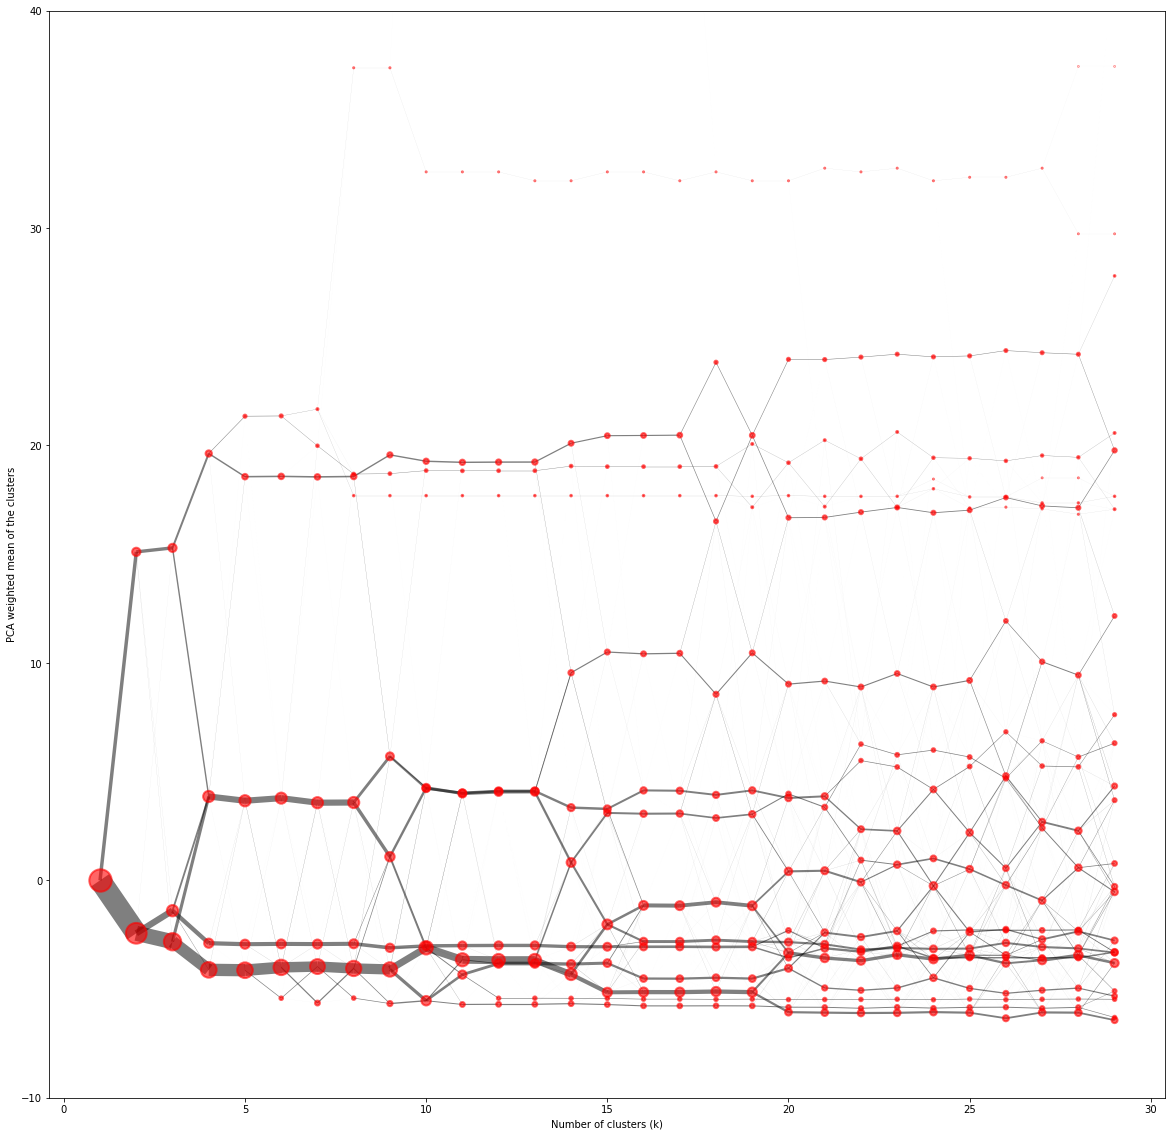

In [8]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 40)

Based on the clustergram, we can assume that 16 clusters is the optimal number. 16 is the first point after all major branching happens and the situation stabilizes.

Before proceeding, we also save clustergam object to a file.

In [9]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

Let's see how 16 clusters based on form look like spatially.

In [19]:
%time km_form = KMeans(n_clusters=16, n_init=100).fit(data)

CPU times: user 14min 57s, sys: 4min 53s, total: 19min 50s
Wall time: 1min 24s


In [4]:
tess = gpd.read_parquet(folder + "tess.pq")

In [20]:
tess['clusters_form'] = km_form.labels_

We can plot the labels based on tessellation or based on buildings, each providing different insights.

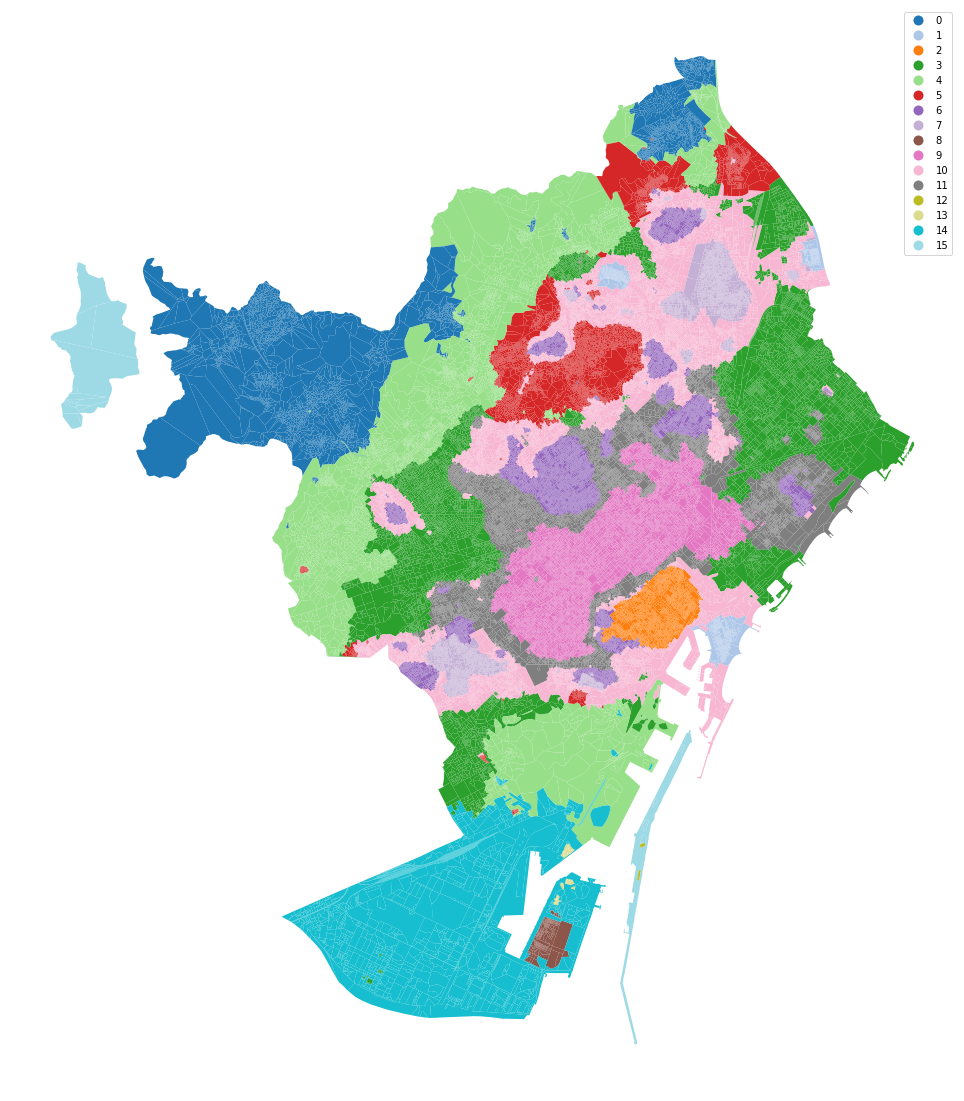

In [21]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

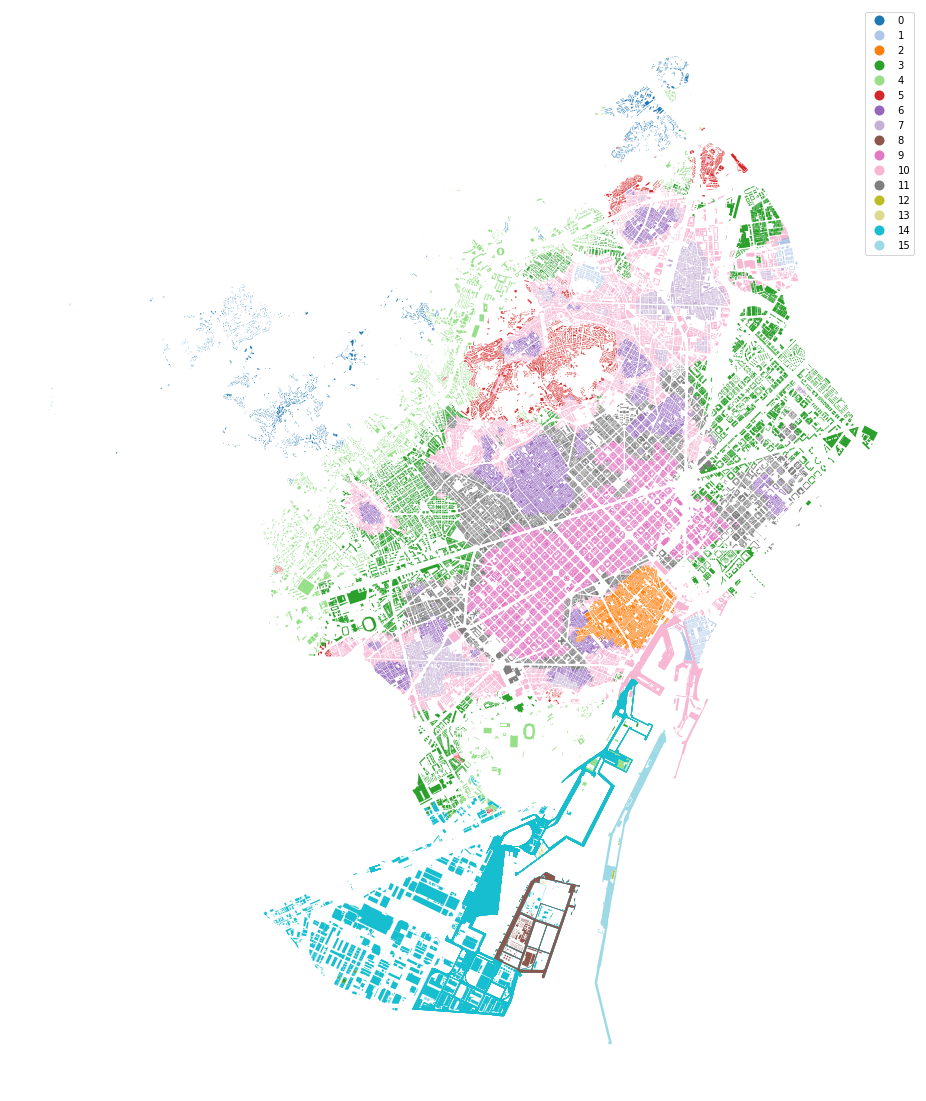

In [22]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.2. Function

Clustering based on function uses only data on function, which we need to prepare.

In [7]:
function = gpd.read_parquet(folder + "func_data.pq")

Let's first remove anything we don't want to keep only the data.

In [11]:
function.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'numberOfDwellings',
       'beginning', 'currentUse', 'age', 'FAMILIA', 'NUM_PARKINGS',
       'NUM_ALTRES', 'HABITANTS', 'heritage_area', 'nodeID', 'heritage',
       'restaurants', 'pois', 'culture', 'parks', 'trees', 'ndvi_min',
       'ndvi_max', 'ndvi_mean', 'ndvi_median'],
      dtype='object')

In [8]:
function_data = function[
    [
        "tID",
        "numberOfDwellings",
        "currentUse",
        "age",
        "FAMILIA",
        "NUM_PARKINGS",
        "NUM_ALTRES",
        "HABITANTS",
        "heritage_area",
        "heritage",
        "restaurants",
        "pois",
        "culture",
        "parks",
        "trees",
        "ndvi_min",
        "ndvi_max",
        "ndvi_mean",
    ]
].set_index("tID")

In [13]:
function_data.head()

numberOfDwellings     currentUse   age     FAMILIA  NUM_PARKINGS  \
tID                                                                     
0                 14.0  1_residential  65.0  Casc Antic      0.118285   
1                 14.0  1_residential  70.0  Casc Antic      0.172536   
2                  1.0  1_residential  84.0  Casc Antic      0.087874   
3                 10.0  1_residential  15.0  Casc Antic      0.084238   
4                  1.0  1_residential  70.0  Casc Antic      0.087551   

     NUM_ALTRES  HABITANTS  heritage_area  heritage  restaurants  pois  \
tID                                                                      
0     20.693664  16.309376           True      3818         1281  1956   
1     30.357385  23.770880           True      3564         1179  1796   
2     15.460904  12.283816           True      3818         1281  1956   
3     14.825760  11.730704          False      3564         1179  1796   
4     15.457345  12.244764          False      3054          966  1450   

     culture  parks  trees  ndvi_min  ndvi_max  ndvi_mean  
tID                                                        
0        414     14      2     -0.13      0.58   0.033225  
1        414     14      4     -0.18      0.63   0.056501  
2        414     14      2     -0.17      0.65   0.080513  
3        414     14      2     -0.09      0.62   0.080907  
4        346      2      2     -0.10      0.39   0.038485

We have some categorical values, so we have to encode them as boolean dummies.

In [9]:
currentUse = pd.get_dummies(function_data.currentUse)
FAMILIA = pd.get_dummies(function_data.FAMILIA)
heritage_area = function_data.heritage_area.astype(int)

Continuous values need to be standardized.

In [10]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data.drop(columns=["currentUse", "FAMILIA", "heritage_area"]))

In [16]:
f_data.shape

(82375, 14)

We can all merge back together.

In [11]:
f_data = np.hstack([f_data, currentUse.values, FAMILIA.values, np.array([heritage_area.values]).T])

In [18]:
f_data.shape

(82375, 42)

In [12]:
f_data[np.isnan(f_data)] = 0

We are using clustergram again.

In [20]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

PCA computed in 0.15984296798706055 seconds.
K=1 fitted in 0.7523233890533447 seconds.
K=2 fitted in 1.244642972946167 seconds.
K=3 fitted in 1.3706672191619873 seconds.
K=4 fitted in 1.6074228286743164 seconds.
K=5 fitted in 1.5692389011383057 seconds.
K=6 fitted in 2.589709758758545 seconds.
K=7 fitted in 2.462235689163208 seconds.
K=8 fitted in 2.792654037475586 seconds.
K=9 fitted in 3.706387758255005 seconds.
K=10 fitted in 5.04081654548645 seconds.
K=11 fitted in 4.576888084411621 seconds.
K=12 fitted in 5.096463203430176 seconds.
K=13 fitted in 5.161396503448486 seconds.
K=14 fitted in 4.879477500915527 seconds.
K=15 fitted in 5.473200082778931 seconds.
K=16 fitted in 6.7620813846588135 seconds.
K=17 fitted in 5.3215789794921875 seconds.
K=18 fitted in 6.588799476623535 seconds.
K=19 fitted in 7.012019872665405 seconds.
K=20 fitted in 6.50932240486145 seconds.
K=21 fitted in 7.3351945877075195 seconds.
K=22 fitted in 6.94942569732666 seconds.
K=23 fitted in 8.456259965896606 sec

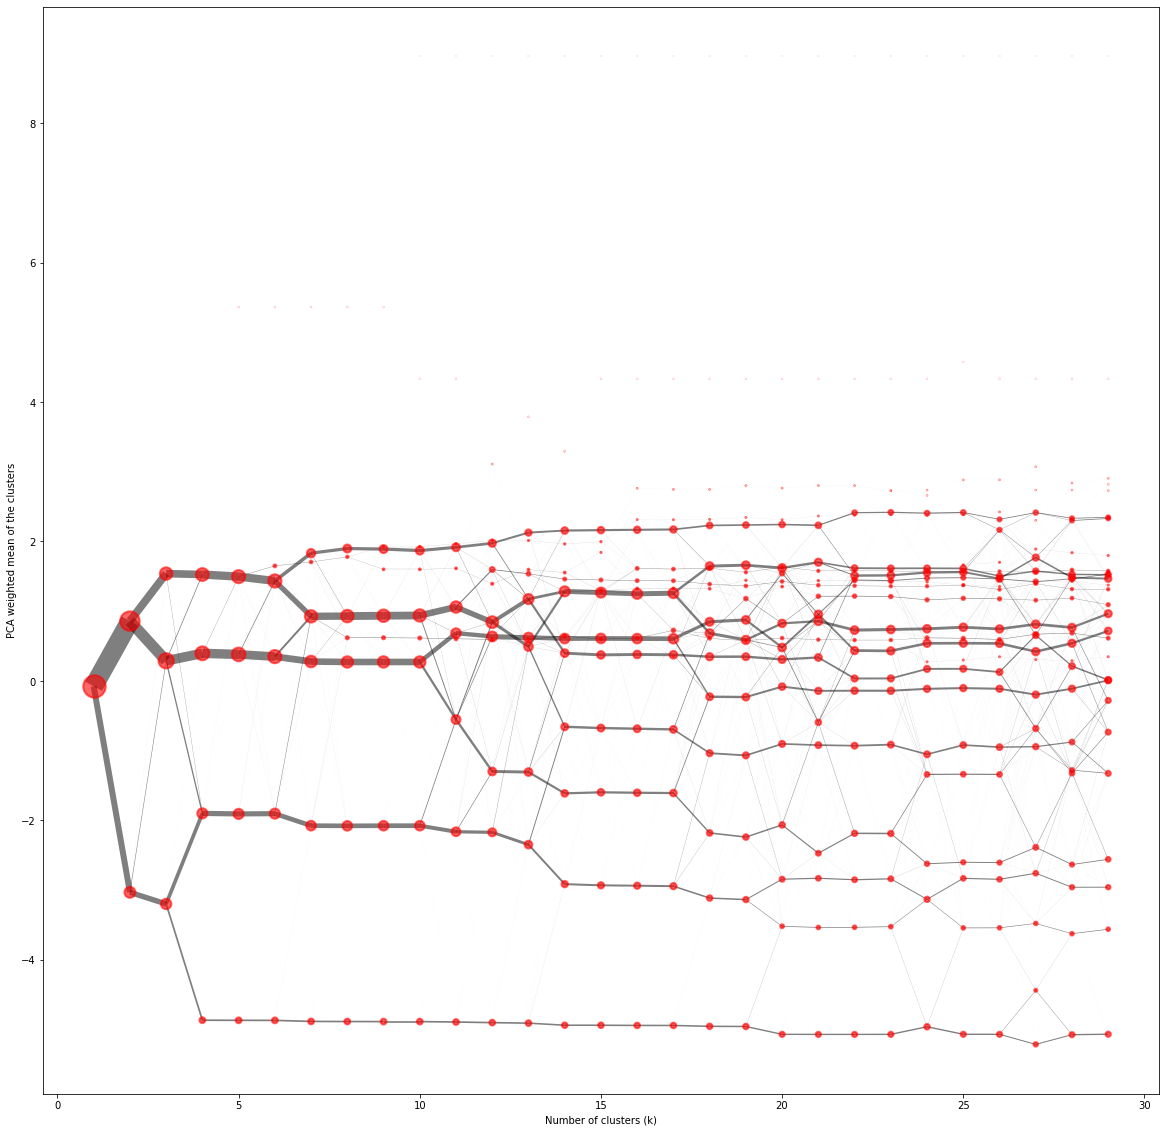

In [21]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

Clustergram should be saved to a file.

In [22]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

We can interpret the diagram as 7 clusters being the optimum.

The figures below show 10 clusters.

In [35]:
km_function = KMeans(n_clusters=10, n_init=100).fit(f_data)

In [37]:
tess['clusters_function'] = km_function.labels_

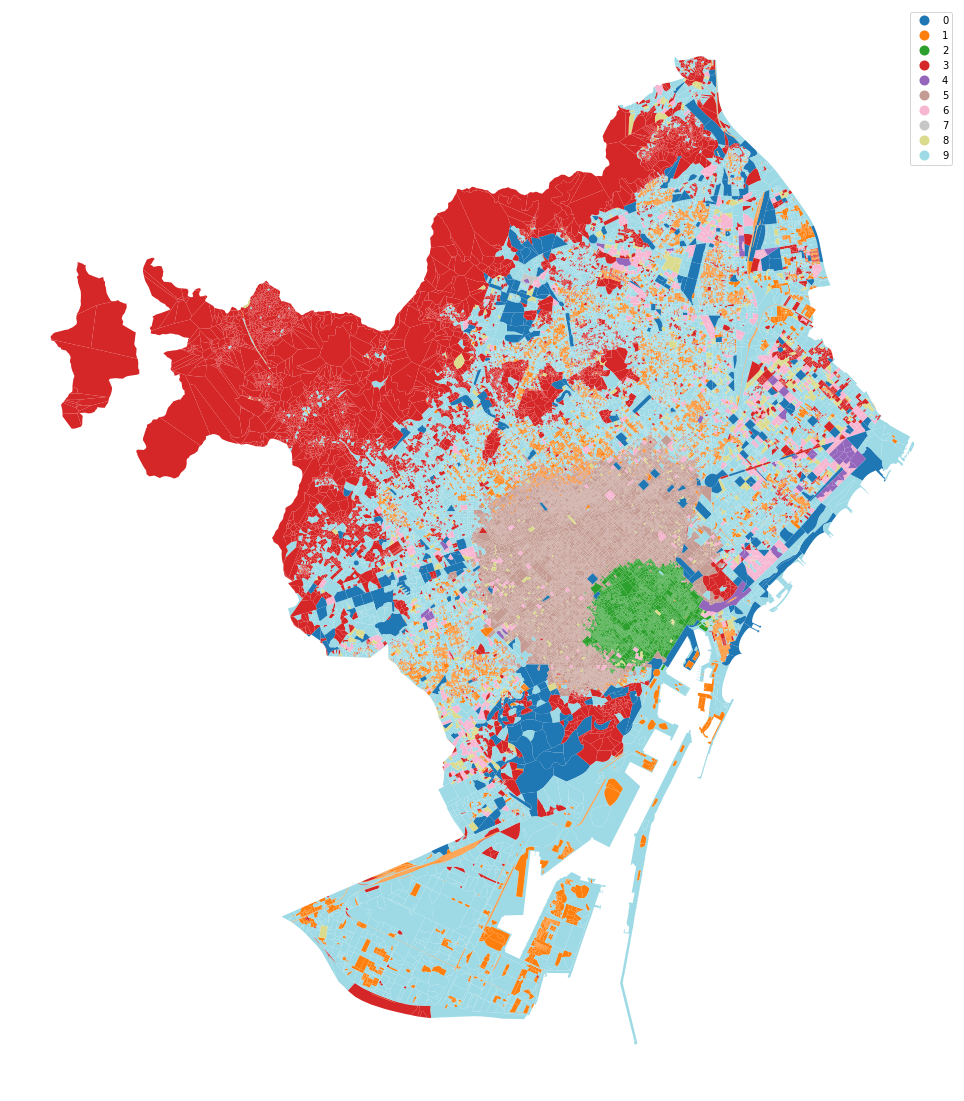

In [38]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

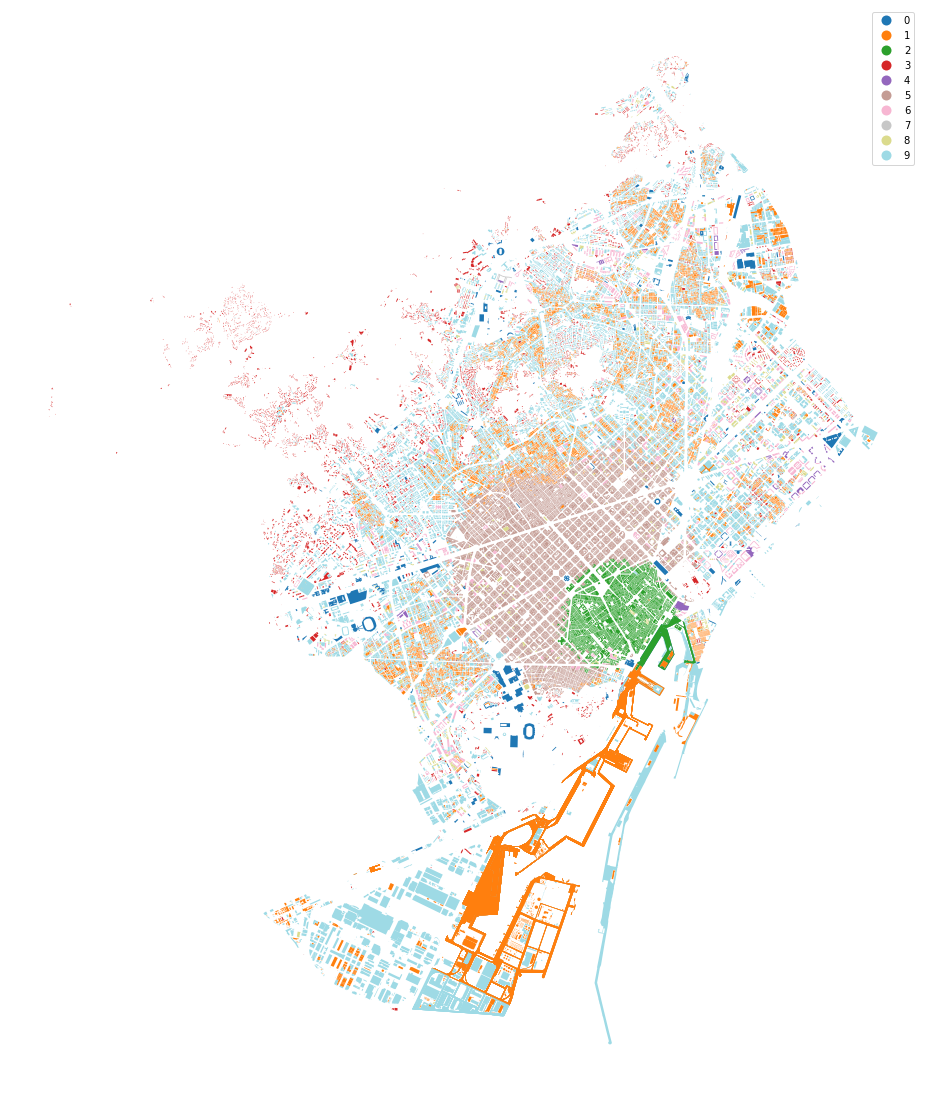

In [39]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.3. Spatial Signatures

Final clustering combines both form and function into a singular classification.

First we stack both preprocessed arrays together and then run clustergram.

In [13]:
ss_data = np.hstack([data, f_data])

In [41]:
cg_ss = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_ss.fit(ss_data)

PCA computed in 0.3966183662414551 seconds.
K=1 fitted in 1.0833287239074707 seconds.
K=2 fitted in 1.9795382022857666 seconds.
K=3 fitted in 2.3725342750549316 seconds.
K=4 fitted in 2.4627268314361572 seconds.
K=5 fitted in 2.9715707302093506 seconds.
K=6 fitted in 4.344547748565674 seconds.
K=7 fitted in 4.179840087890625 seconds.
K=8 fitted in 4.612930536270142 seconds.
K=9 fitted in 5.237586975097656 seconds.
K=10 fitted in 5.708490610122681 seconds.
K=11 fitted in 6.0753254890441895 seconds.
K=12 fitted in 8.536413431167603 seconds.
K=13 fitted in 8.562976360321045 seconds.
K=14 fitted in 7.8622565269470215 seconds.
K=15 fitted in 9.060364723205566 seconds.
K=16 fitted in 9.940111875534058 seconds.
K=17 fitted in 10.316210508346558 seconds.
K=18 fitted in 10.548905849456787 seconds.
K=19 fitted in 12.181637287139893 seconds.
K=20 fitted in 11.191916942596436 seconds.
K=21 fitted in 12.614004135131836 seconds.
K=22 fitted in 13.414296865463257 seconds.
K=23 fitted in 12.5095114707

(-10.0, 25.0)

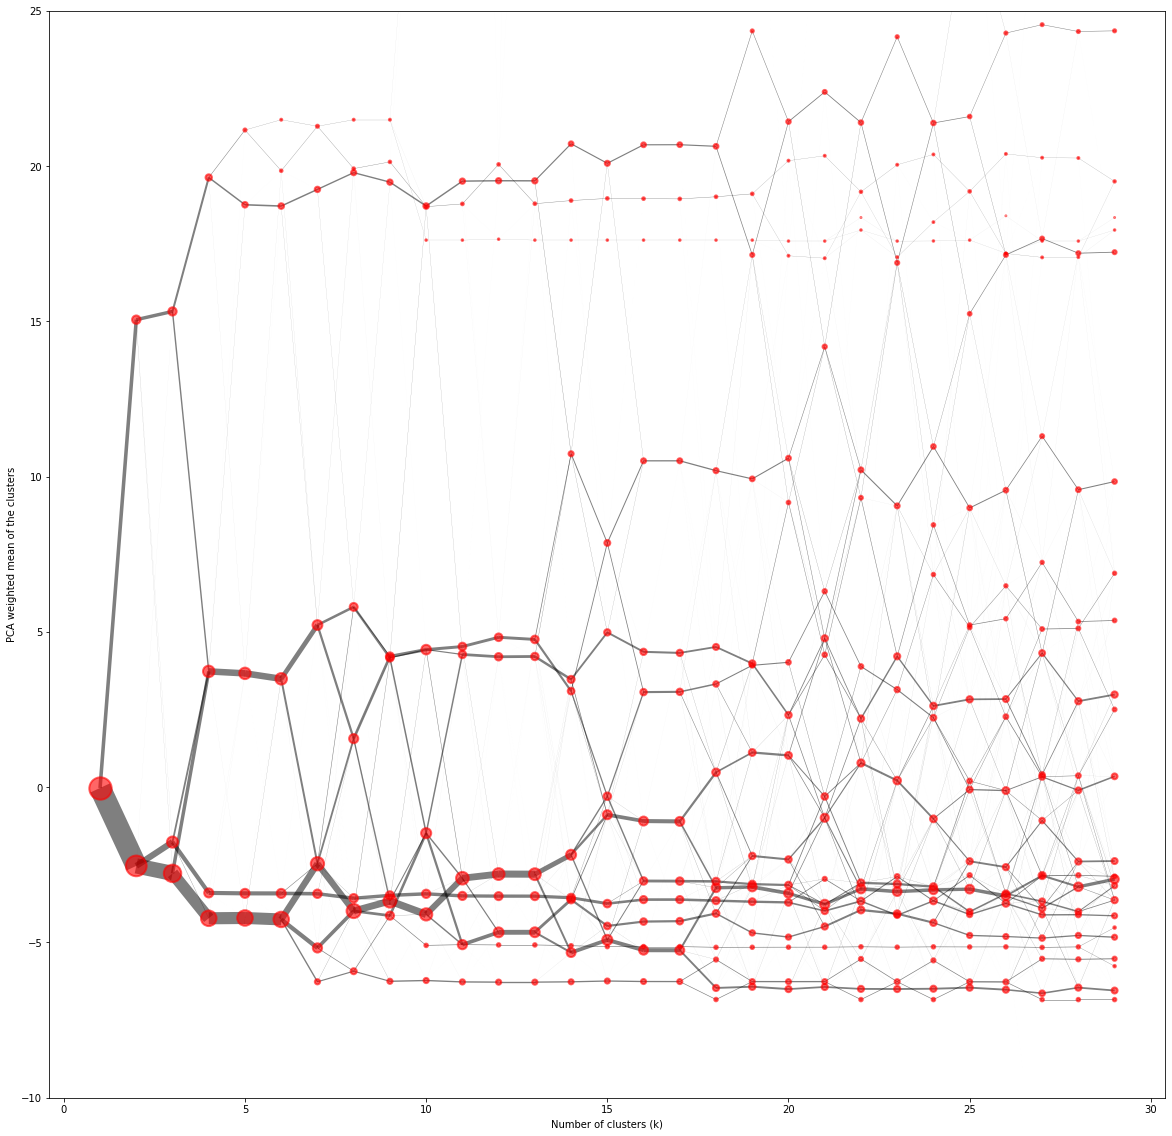

In [44]:
ax = cg_ss.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 25)

In [43]:
with open(folder + 'clustergram_ss.pickle','wb') as f:
    pickle.dump(cg_ss, f)

The optimal number in this case seems to be 16 clusters. We run final clustering with 1000 initiazations and fixed random state for reproducibility.

In [14]:
%time km = KMeans(n_clusters=16, n_init=1000, random_state=12345).fit(ss_data)

CPU times: user 2h 31min 5s, sys: 54min 5s, total: 3h 25min 11s
Wall time: 14min 41s


In [15]:
tess['clusters'] = km.labels_

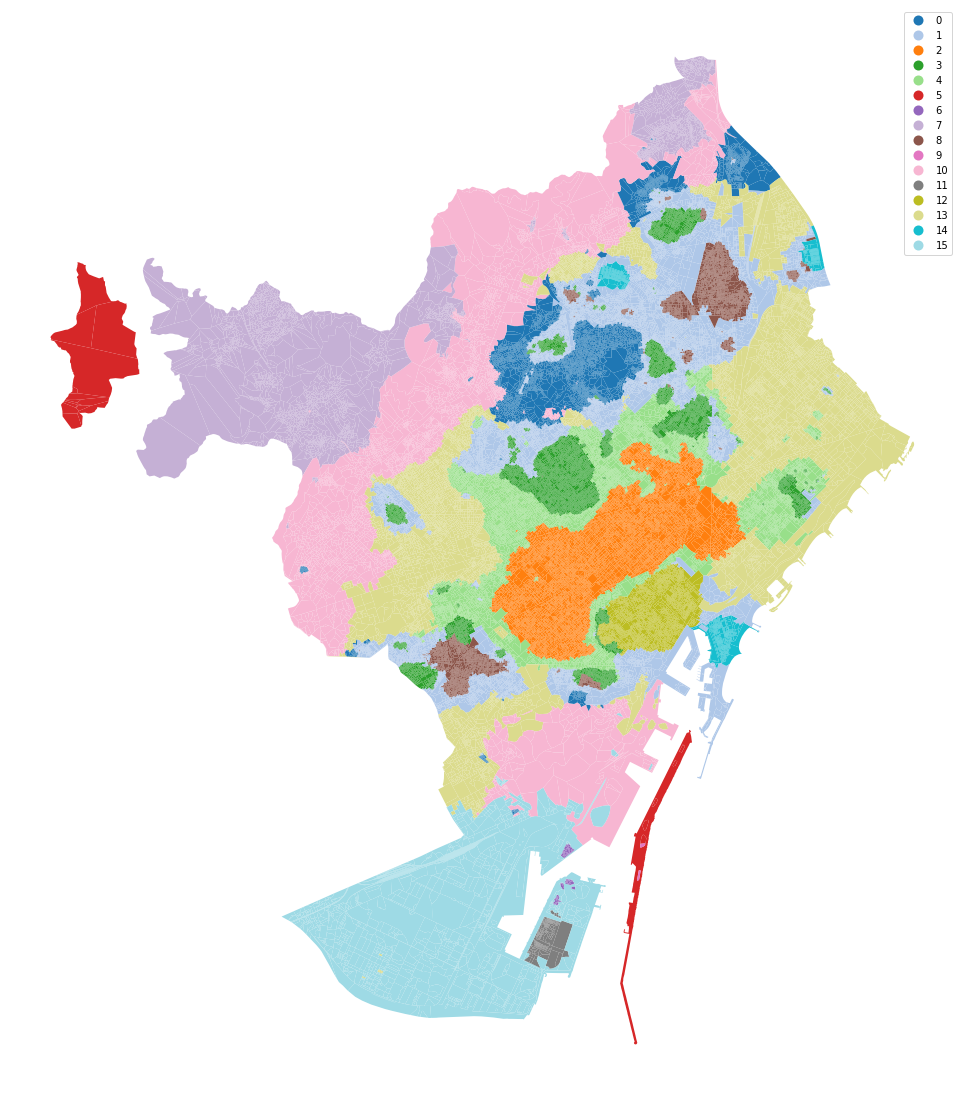

In [17]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

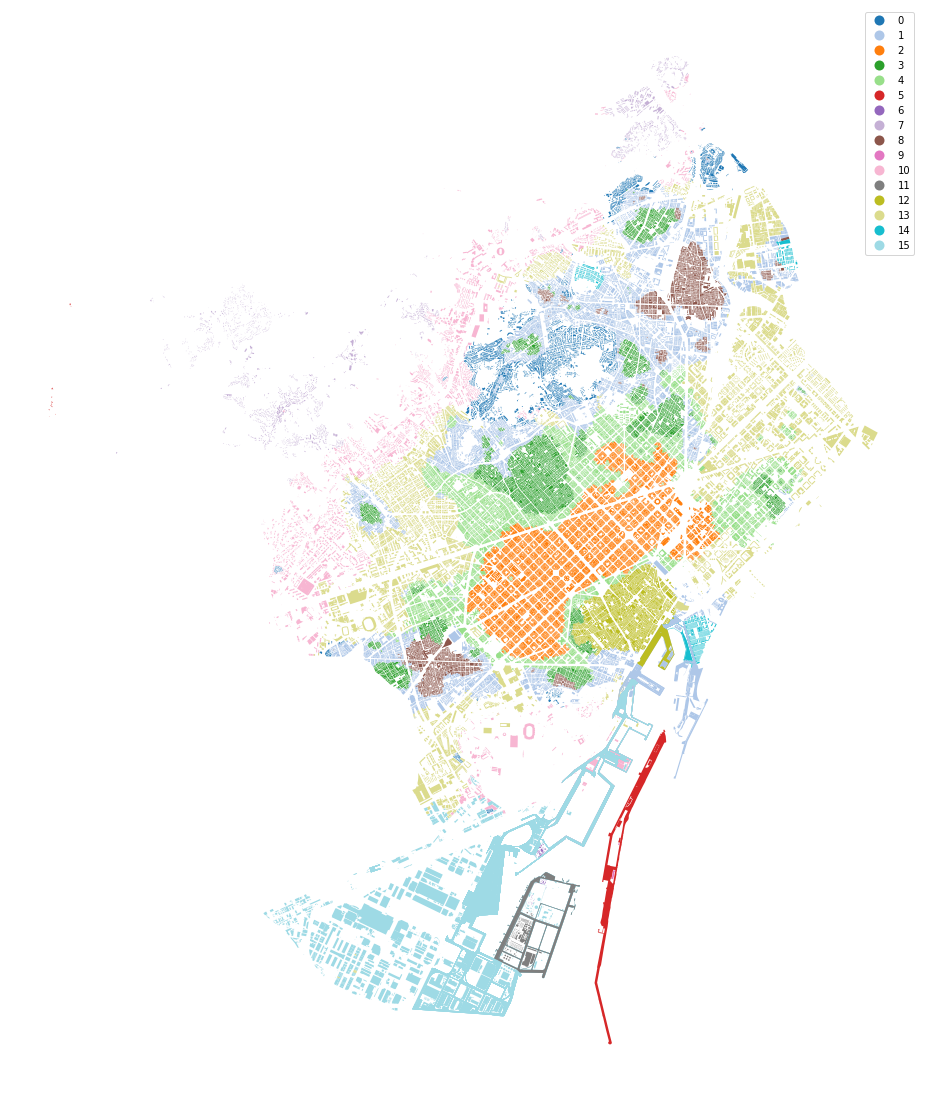

In [16]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [18]:
tess[['tID', 'clusters',]].to_csv(folder + "FINAL_cluster_labels.csv")

#### Generate signatures

As a final step, we can generate a geometry representing spatial singatures as a combination of contiguous tessellation cells belonging to a single cluster. Since we have to dissolve a large number of polygons, we use dask_geopandas to parallelize the procedure.

First we create a local cluster.

In [4]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:42515' processes=16 threads=16, memory=134.91 GB>

We read only 'tessellation' columns and cluster labels. The resulting geometry will not be enclosed tessellation anymore so we can already rename it to generic "geometry".

In [5]:
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation']).rename_geometry("geometry")
clusters = pd.read_csv(folder + "FINAL_cluster_labels.csv", index_col=0)

In [6]:
tess['cluster'] = clusters.clusters.values

`dask_dissolve` mimics the behaviour of `geopandas.dissolve`, just based on parallel implementation using `dask-geopandas`.

In [7]:
%%time
ddf = dask_geopandas.from_geopandas(tess.sort_values('cluster'), npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:31: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.array(


CPU times: user 7.11 s, sys: 1.69 s, total: 8.79 s
Wall time: 24.7 s


<AxesSubplot:>

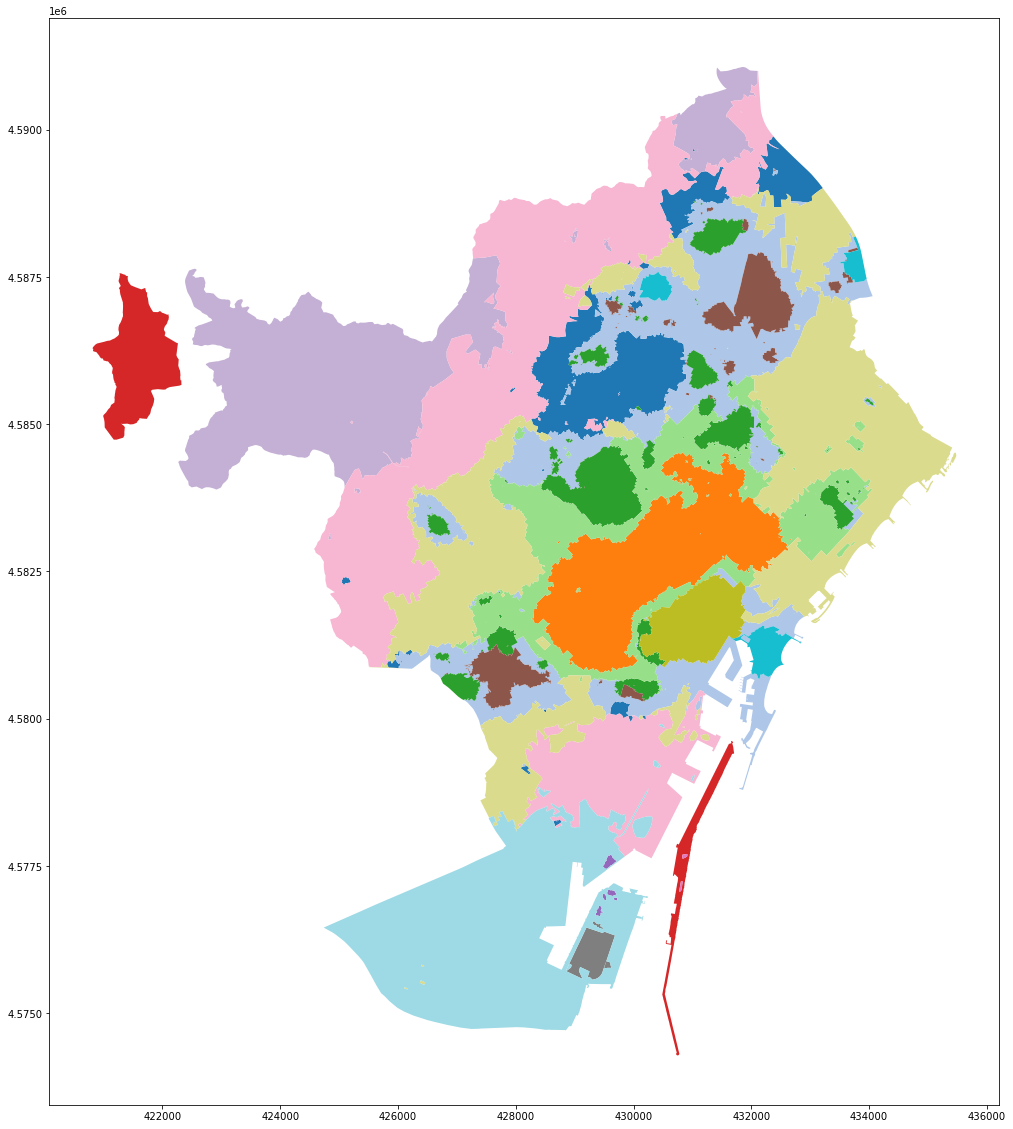

In [10]:
final.plot('cluster', categorical=True, figsize=(20, 20), cmap='tab20')

Finally, we explode the geometries to get multiple singatures of the same kind instead of a single multipolygon. (The intial `reset_index` is here to avoid bug in geopandas.)

In [11]:
final.reset_index(drop=True).explode().reset_index(drop=True).to_parquet(folder + "signatures.pq")

Before we end, we close dask client.

In [12]:
client.close()

# 4. Figures

Finally, we create final figures.

In [5]:
final = gpd.read_parquet(folder + "signatures.pq")

In [11]:
enc = gpd.read_parquet(folder + "enclosures.pq")

In [8]:
sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})

In [24]:
cmap = ugg.get_colormap(final.cluster.nunique(), randomize=False)

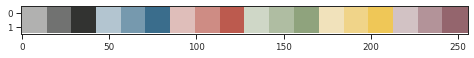

In [27]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(8, .5))
ax.imshow(gradient, aspect='auto', cmap=cmap)

In [34]:
cols = cmap.colors
symbology = {0: cols[17],
             1: cols[4],
             2: cols[8],
             3: cols[6],
             4: cols[14],
             5: cols[7],
             6: cols[9],
             7: cols[13],
             8: cols[11],
             9: cols[12],
             10: cols[10],
             11: cols[15],
             12: cols[5],
             13: cols[3],
             14: cols[16],
             15: cols[0]
            }

In [13]:
df = final.set_crs(enc.crs).to_crs(3857)

In [14]:
token = "pk.eyJ1IjoibWFydGluZmxlaXMiLCJhIjoiY2tsNmhlemtxMmlicTJubXN6and5aTc2NCJ9.l7nSUXM7ZRjAWTB7oXiswQ"

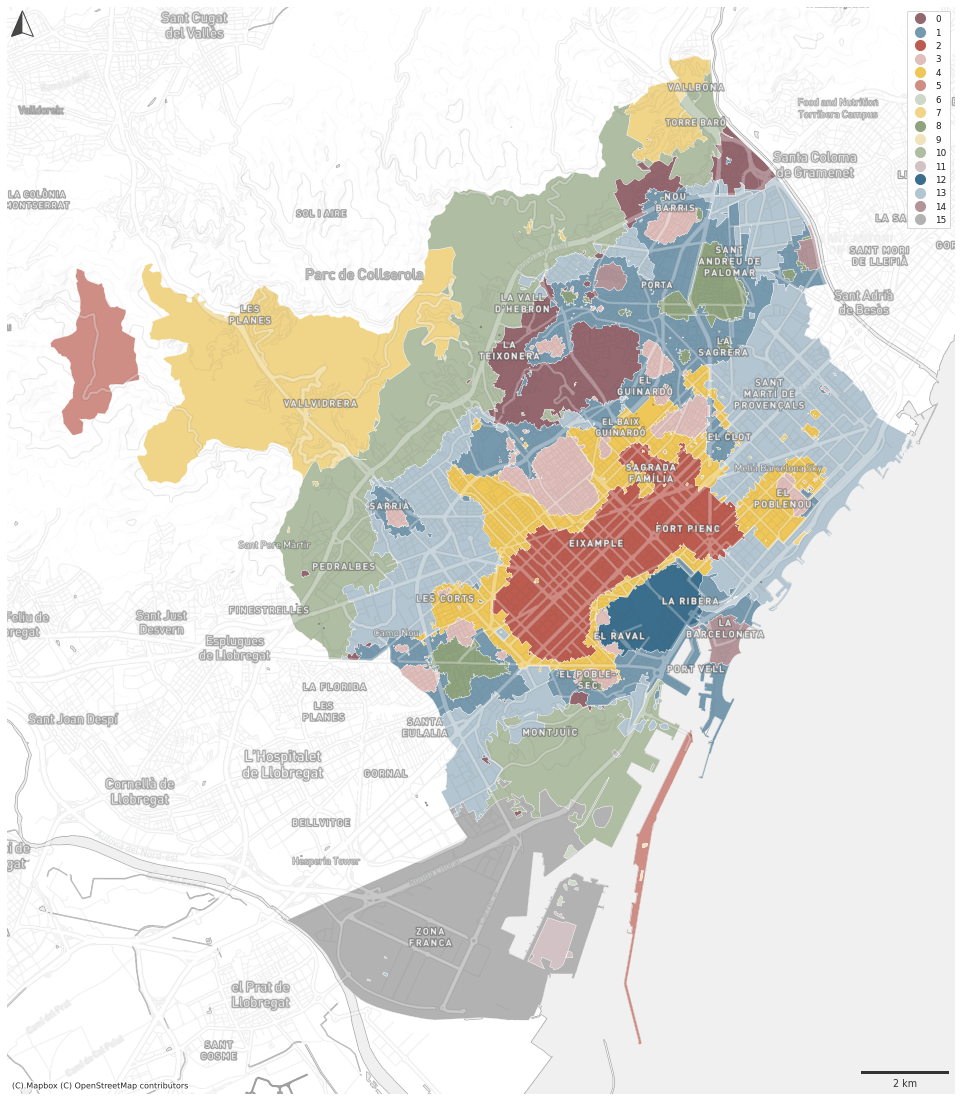

In [44]:
ax = df.plot(color=df['cluster'].map(symbology), figsize=(20, 20), zorder=1, linewidth=.3, edgecolor='w', alpha=1)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color=ugg.COLORS[0],
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

ugg.north_arrow(plt.gcf(), ax, 0, size=.026, linewidth=1, color=ugg.COLORS[0], loc="upper left", pad=.002, alpha=.9)

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=True)
ax.add_artist(leg_points)
plt.savefig(folder + "signatures.png", dpi=300, bbox_inches="tight")

In [39]:
tess = gpd.read_parquet(folder + "tess.pq").set_geometry('buildings')
clusters = pd.read_csv(folder + "FINAL_cluster_labels.csv", index_col=0)
tess['cluster'] = clusters.clusters.values

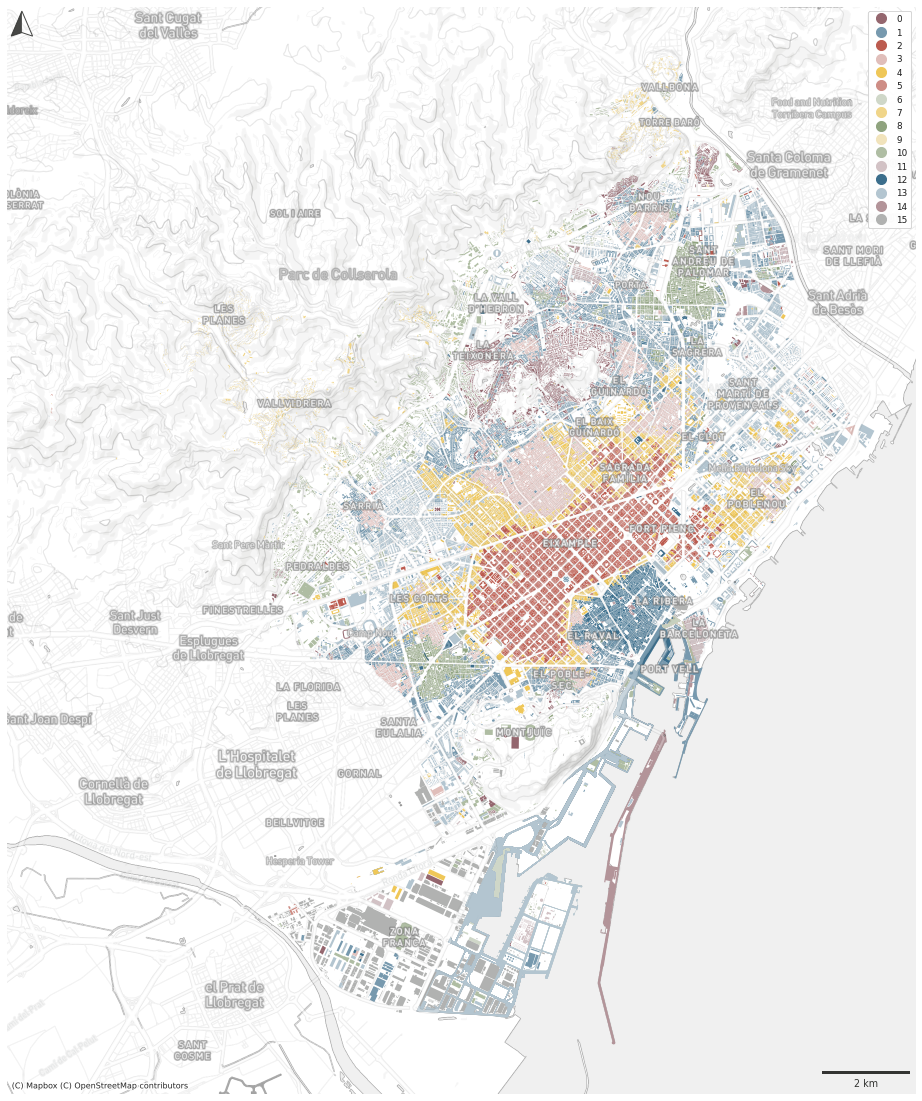

In [43]:
ax = tess.to_crs(3857).plot(color=tess['cluster'].map(symbology), figsize=(20, 20), zorder=1, alpha=1)
contextily.add_basemap(ax, crs=df.crs, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
contextily.add_basemap(ax, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
contextily.add_basemap(ax, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color=ugg.COLORS[0],
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

ugg.north_arrow(plt.gcf(), ax, 0, size=.026, linewidth=1, color=ugg.COLORS[0], loc="upper left", pad=.002, alpha=.9)

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=True)
ax.add_artist(leg_points)
plt.savefig(folder + "signatures_buildings.png", dpi=300, bbox_inches="tight")